## Header

In [1]:
%load_ext autoreload
%autoreload 2

from neutronMonitorComparisonTools import *
import ParticleRigidityCalculationTools as PRCT
from scipy.interpolate import interp1d

import pandas as pd

import CosRayModifiedISO as CRMI

from AniMAIRE import AniMAIRE
from AniMAIRE import dose_plotting
from AniMAIRE.anisotropic_MAIRE_engine.spectralCalculations.rigiditySpectrum import DLRmodelSpectrum, CommonModifiedPowerLawSpectrum, CommonModifiedPowerLawSpectrumSplit
import ParticleRigidityCalculationTools as PRCT

import os
import matplotlib.dates as mdates
import heapq

Please set KPDATA_PATH environment variable


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/chrisswdavis/.local/lib/python3.8/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/chrisswdavis/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'params_to_use' of function 'sum_yield_values'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/data/NM64_responses.py", line 87:
@njit
def sum_yield_values(params_to_use, R_value):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', size=18)

In [3]:
default_to_saving = True

In [4]:
def add_dose_maps(left_map,right_map):

    new_map = left_map.copy()

    list_of_dose_columns = list(right_map.columns[3:])
    for col_to_ignore in ["datetime","altitude (kft)"]: 
        try:
            list_of_dose_columns.remove(col_to_ignore)
        except ValueError:
            pass

    new_map[list_of_dose_columns] = new_map[list_of_dose_columns] + right_map[list_of_dose_columns]

    return new_map

In [5]:
def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

In [6]:
def save_image_to_paper_dir(base_file_name:str,save=default_to_saving, save_legend_separately=True,figure_number=None,additional_DF_to_save=None,additional_DF_label=""):

    if figure_number is None:
        dir_to_save_to = "other_images"
    else:
        dir_to_save_to = f"figure_{figure_number}"

    if not os.path.exists(dir_to_save_to):
        os.makedirs(dir_to_save_to)

    if save is True:
        if save_legend_separately is True:
            plt.savefig(f"./{dir_to_save_to}/{base_file_name}_with_legend.png",bbox_inches="tight",dpi=300)
            plt.savefig(f"./{dir_to_save_to}/{base_file_name}_with_legend.svg",bbox_inches="tight")

            #handles, labels = plt.gca().get_legend_handles_labels()
            try:
                export_legend(plt.gca().get_legend(),f"./{dir_to_save_to}/{base_file_name}_legend.png")
                export_legend(plt.gca().get_legend(),f"./{dir_to_save_to}/{base_file_name}_legend.svg")
            except:
                pass

            plt.savefig(f"./{dir_to_save_to}/{base_file_name}.png",dpi=300)
            plt.savefig(f"./{dir_to_save_to}/{base_file_name}.svg")
        else:
            plt.savefig(f"./{dir_to_save_to}/{base_file_name}.png",bbox_inches="tight",dpi=300)
            plt.savefig(f"./{dir_to_save_to}/{base_file_name}.svg",bbox_inches="tight")

    if not (additional_DF_to_save is None):

        additional_DF_to_save.to_pickle(f"./{dir_to_save_to}/{base_file_name}{additional_DF_label}.pkl")
        additional_DF_to_save.to_csv(f"./{dir_to_save_to}/{base_file_name}{additional_DF_label}.csv")

In [7]:
Mishev_params_for_event = importParamsFromMishevPDF_GLE71()

[                 Station Latitude (deg)  Longitude (deg)  Pc (GV)  \
0        Alma Aty (AATY)          43.25            76.92     6.67   
1         Apatity (APTY)          67.55            33.33     0.48   
2          Athens (ATHN)          37.98            23.78     8.42   
3          Baksan (BKSN)          43.28            42.69     5.60   
4     Forth Smith (FSMT)          60.02           248.07     0.25   
5          Inuvik (INVK)          68.35           226.28     0.16   
6         Irkutsk (IRKT)          52.47           104.03     3.23   
7         Irkutsk (IRK2)          51.37           100.55     3.23   
8         Irkutsk (IRK3)          51.29           100.55     3.23   
9    Jungfraujoch (JUNG)          46.55             7.98     4.46   
10      Kerguelen (KERG)         −49.35            70.25     1.01   
11           Kiel (KIEL)          54.33            10.13     2.22   
12       Kingston (KGSN)         −42.99           147.29     1.81   
13  Lomnicky Štit (LMKS)         

In [8]:
Force_Field_GCR_DF = pd.read_csv("old_OuluCalculationComponents/GCRCalculationComponents.csv")
Force_Field_GCR_proton_rigidity_DF = PRCT.convertParticleEnergySpecToRigiditySpec(particleKineticEnergyInMeV=Force_Field_GCR_DF["EnergyPerNucleon"] * 1000.0, 
                                             fluxInEnergyMeVform=(Force_Field_GCR_DF["GCRProtonSpectrum"] / 10_000) / 1000.0,
                                             particleChargeAU=1,
                                             particleMassAU=1)
Force_Field_GCR_alpha_rigidity_DF = PRCT.convertParticleEnergySpecToRigiditySpec(particleKineticEnergyInMeV=Force_Field_GCR_DF["EnergyPerNucleon"] * (1000.0 * 4), 
                                             fluxInEnergyMeVform=(Force_Field_GCR_DF["GCRAlphaSpectrum"] / 10_000) / (1000.0 * 4),
                                             particleChargeAU=2,
                                             particleMassAU=4)

Force_Field_GCR_proton_rigidity_spec = interp1d(Force_Field_GCR_proton_rigidity_DF["Rigidity"], Force_Field_GCR_proton_rigidity_DF["Rigidity distribution values"],bounds_error=False, fill_value=0.0)
Force_Field_GCR_alpha_rigidity_spec = interp1d(Force_Field_GCR_alpha_rigidity_DF["Rigidity"], Force_Field_GCR_alpha_rigidity_DF["Rigidity distribution values"],bounds_error=False, fill_value=0.0)

In [9]:
thirtynine_kft_in_km = 11.89

In [10]:
fifty_kft_in_km = 15.24

In [11]:
spec_to_use = lambda J0,gamma,deltaGamma:CommonModifiedPowerLawSpectrum(J0,gamma,deltaGamma, lowerLimit=0.814529,upperLimit=21.084584)

In [12]:
test_rigidity_values_in_GV = np.linspace(0.5,25,1000)

In [13]:
Mishev_params_for_event.head()

J0  gamma  deltaGamma  sigma_1_Squared     B  sigma_2_Squared  \
0  128000.0   3.60        0.50             0.38  0.45             1.20   
1  201000.0   3.63        0.30             0.42  0.53             1.21   
2  253000.0   4.68        0.65             1.30  0.52             1.52   
3  252000.0   4.69        0.68             1.35  0.75             2.17   
4  246000.0   4.90        0.62             1.35  0.55             1.80   

   alpha_prime    Phi  Lambda                  datetime  
0         2.38 -21.50   58.20 2012-05-17 01:55:00+00:00  
1         2.53 -21.44   51.59 2012-05-17 02:00:00+00:00  
2         2.43 -20.50   60.00 2012-05-17 02:05:00+00:00  
3         2.43 -23.51   63.70 2012-05-17 02:10:00+00:00  
4         2.41 -18.50   64.00 2012-05-17 02:15:00+00:00

In [14]:
test_Mishev_spec_vals = np.vectorize(spec_to_use(Mishev_params_for_event.iloc[0]["J0"],Mishev_params_for_event.iloc[0]["gamma"],Mishev_params_for_event.iloc[0]["deltaGamma"]))(test_rigidity_values_in_GV)
test_Mishev_spec_vals_last = np.vectorize(spec_to_use(Mishev_params_for_event.iloc[-1]["J0"],Mishev_params_for_event.iloc[-1]["gamma"],Mishev_params_for_event.iloc[-1]["deltaGamma"]))(test_rigidity_values_in_GV)

In [15]:
test_energy_spec_DF = PRCT.convertParticleEnergySpecToRigiditySpec(test_rigidity_values_in_GV * 1000,test_Mishev_spec_vals / 1000,particleMassAU = 1,particleChargeAU = 1)
test_energy_spec_DF_last = PRCT.convertParticleEnergySpecToRigiditySpec(test_rigidity_values_in_GV * 1000,test_Mishev_spec_vals_last / 1000,particleMassAU = 1,particleChargeAU = 1)

test_energy_spec_DF.head()

Rigidity  Rigidity distribution values
0  1.090079                           0.0
1  1.122239                           0.0
2  1.154023                           0.0
3  1.185463                           0.0
4  1.216585                           0.0

(0.1, 25)

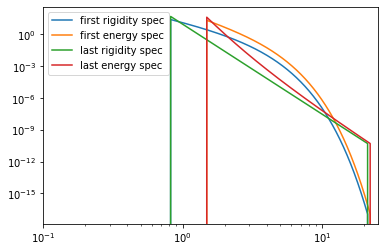

In [16]:
plt.plot(test_rigidity_values_in_GV,test_Mishev_spec_vals,label="first rigidity spec")
plt.plot(test_energy_spec_DF["Rigidity"],test_energy_spec_DF["Rigidity distribution values"],label="first energy spec")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlim([0.1,25])
plt.plot(test_rigidity_values_in_GV,test_Mishev_spec_vals_last,label="last rigidity spec")
plt.plot(test_energy_spec_DF_last["Rigidity"],test_energy_spec_DF_last["Rigidity distribution values"],label="last energy spec")
plt.yscale("log")
plt.xscale("log")
plt.legend()

plt.xlim([0.1,25])

## Generating Single AsymptoticDirectionDFs

In [17]:
anisotropic_test_DF = get_percentage_increase_at_NM(Mishev_params_for_event.iloc[0]["datetime"], 
                                                    Mishev_params_for_event.iloc[0],"OULU", 
                                                    anisotropy_mode = "double_power_law_gaussian",
                                                    generate_NM_count_rates = False,
                                                    location_lat_displacement = 0.0,
                                                    location_long_displacement = 0.0,
                                                    )

weighting_factors_DF_vertical_only = pd.read_pickle("weighting_factor_DF.pkl")
weighting_factors_DF_vertical_only.columns

/home/chrisswdavis/AniMAIRE-public/notebooks_and_data_and_figures_for_paper/neutronMonitorComparisonTools.py:473: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if lats_and_longs_to_run_for=="default_MAIRE":
/home/chrisswdavis/AniMAIRE-public/notebooks_and_data_and_figures_for_paper/neutronMonitorComparisonTools.py:480: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if altitudes_to_run_for_in_km == "default_MAIRE":


running MAGNETOCOSMICS to acquire asymptotic directions...
assigning asymptotic coordinates
acquiring pitch angles...


successfully converted asymptotic directions
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


output dose rates calculated successfully!
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors
/home/chrisswdavis/.local/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


output dose rates calculated successfully!
Success!
running MAGNETOCOSMICS to acquire asymptotic directions...
assigning asymptotic coordinates
acquiring pitch angles...


successfully converted asymptotic directions
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors


output dose rates calculated successfully!
Success!
running MAGNETOCOSMICS to acquire asymptotic directions...
assigning asymptotic coordinates
acquiring pitch angles...


/home/chrisswdavis/.local/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


successfully converted asymptotic directions
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


output dose rates calculated successfully!
Success!


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors


Index(['Rigidity', 'initialLatitude', 'initialLongitude', 'Filter', 'Lat',
       'Long', 'Xpla', 'Ypla', 'Zpla', 'initialZenith', 'initialAzimuth',
       'THETApla', 'PHIpla', 'angleDiffRad', 'weightingFactor', 'Rlower',
       'Reffective', 'Rupper', 'angleBetweenIMFinRadians',
       'PitchAngleWeightingFactor', 'RigidityWeightingFactor',
       'fullRigidityPitchWeightingFactor', 'Energy',
       'fullEnergyPitchWeightingFactor'],
      dtype='object')

In [18]:
## commented a lot of these lines out because they take a long time to run!

# full_map_anisotropic_test_DF = get_percentage_increase_at_NM(Mishev_params_for_event.iloc[0]["datetime"], 
#                                                     Mishev_params_for_event.iloc[0],"OULU", 
#                                                     anisotropy_mode = "double_power_law_gaussian",
#                                                     generate_NM_count_rates = False,
#                                                     location_lat_displacement = 0.0,
#                                                     location_long_displacement = 0.0,
#                                                     altitudes_to_run_for_in_km = thirtynine_kft_in_km,
#                                                     lats_and_longs_to_run_for="default_MAIRE",
#                                                     )

#full_map_weighting_factors_DF_vertical_only = pd.read_pickle("weighting_factor_DF.pkl")

# import shutil
# shutil.copyfile("weighting_factor_DF.pkl","weighting_factor_DF_full_map_39kft.pkl")

full_map_weighting_factors_DF_vertical_only = pd.read_pickle("weighting_factor_DF_full_map_39kft.pkl")
full_map_weighting_factors_DF_vertical_only.columns

Index(['Rigidity', 'initialLatitude', 'initialLongitude', 'Filter', 'Lat',
       'Long', 'Xpla', 'Ypla', 'Zpla', 'initialZenith', 'initialAzimuth',
       'THETApla', 'PHIpla', 'angleDiffRad', 'weightingFactor', 'Rlower',
       'Reffective', 'Rupper', 'Energy', 'angleBetweenIMFinRadians',
       'PitchAngleWeightingFactor', 'RigidityWeightingFactor',
       'fullRigidityPitchWeightingFactor', 'fullEnergyPitchWeightingFactor'],
      dtype='object')

In [19]:
anisotropic_test_DF_9_dirs = get_percentage_increase_at_NM(Mishev_params_for_event.iloc[0]["datetime"], 
                                                    Mishev_params_for_event.iloc[0],"OULU", 
                                                    anisotropy_mode = "double_power_law_gaussian",
                                                    generate_NM_count_rates = False,
                                                    location_lat_displacement = 0.0,
                                                    location_long_displacement = 0.0,
                                                    use_default_9_zeniths_azimuths=True,
                                                    )

weighting_factors_DF_9_dirs = pd.read_pickle("weighting_factor_DF.pkl")
weighting_factors_DF_9_dirs.columns

running MAGNETOCOSMICS to acquire asymptotic directions...
assigning asymptotic coordinates
acquiring pitch angles...


/home/chrisswdavis/AniMAIRE-public/notebooks_and_data_and_figures_for_paper/neutronMonitorComparisonTools.py:473: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if lats_and_longs_to_run_for=="default_MAIRE":
/home/chrisswdavis/AniMAIRE-public/notebooks_and_data_and_figures_for_paper/neutronMonitorComparisonTools.py:480: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if altitudes_to_run_for_in_km == "default_MAIRE":


successfully converted asymptotic directions
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


output dose rates calculated successfully!
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors


output dose rates calculated successfully!
Success!
running MAGNETOCOSMICS to acquire asymptotic directions...
assigning asymptotic coordinates
acquiring pitch angles...


/home/chrisswdavis/.local/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


successfully converted asymptotic directions
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors


output dose rates calculated successfully!
Success!
running MAGNETOCOSMICS to acquire asymptotic directions...
assigning asymptotic coordinates
acquiring pitch angles...


/home/chrisswdavis/.local/lib/python3.8/site-packages/spacepy/coordinates.py:248: DeprecationWarning: No coordinate backend specified; using SpacePy. This default changed from IRBEM in version 0.4.0
  warnings.warn('No coordinate backend specified; using SpacePy.'


successfully converted asymptotic directions
assigning pitch angle weighting factors...
calculating pitch angle weighting factors...


calculating rigidity weighting factors...


calculating rigidity + pitch combined weighting factors...


calculating energy + pitch combined weighting factors...
converting spectra and asymptotic directions to particle fluxes and dose rates...


output dose rates calculated successfully!
Success!


/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/anisotropic_MAIRE_engine/singleParticleEngineInstance.py:78: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sortedOutputDoseRates.weighting_factor_input_DF = df_with_weighting_factors


Index(['Rigidity', 'initialLatitude', 'initialLongitude', 'Filter', 'Lat',
       'Long', 'Xpla', 'Ypla', 'Zpla', 'initialZenith', 'initialAzimuth',
       'THETApla', 'PHIpla', 'angleDiffRad', 'weightingFactor', 'Rlower',
       'Reffective', 'Rupper', 'angleBetweenIMFinRadians',
       'PitchAngleWeightingFactor', 'RigidityWeightingFactor',
       'fullRigidityPitchWeightingFactor', 'Energy',
       'fullEnergyPitchWeightingFactor'],
      dtype='object')

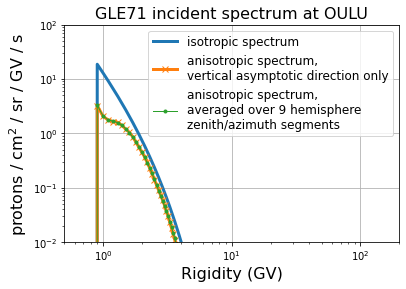

In [20]:
weighting_factors_DF_vertical_only.plot("Rigidity","RigidityWeightingFactor",lw=3)
#weighting_factors_DF_vertical_only.plot("Rigidity","weightingFactor",ax=plt.gca())
weighting_factors_DF_vertical_only.plot("Rigidity","fullRigidityPitchWeightingFactor",ax=plt.gca(),lw=3,marker="x")
weighting_factors_DF_9_dirs.plot("Rigidity","fullRigidityPitchWeightingFactor",ax=plt.gca(),lw=1,marker="o",ms=3)
plt.yscale("log")
plt.xscale("log")

plt.grid(True)

plt.ylim([1e-2,1e2])
plt.xlim([5e-1,2e2])

plt.ylabel(f"protons / cm$^2$ / sr / GV / s",fontsize=16)
plt.xlabel("Rigidity (GV)",fontsize=16)
plt.title("GLE71 incident spectrum at OULU",fontsize=16)

plt.legend(["isotropic spectrum",
"anisotropic spectrum,\nvertical asymptotic direction only",
"anisotropic spectrum,\naveraged over 9 hemisphere\nzenith/azimuth segments"],
fontsize=12)

#plt.title(f"GLE proton spectra\nlatitude=65.02$\degree$, longitude=25.5$\degree$\n{str(anisotropic_test_DF_9_dirs['datetime'].iloc[0])}")

save_image_to_paper_dir("GLE_spectra_comparison",figure_number=2,additional_DF_to_save=weighting_factors_DF_vertical_only,additional_DF_label="vertical_only")
save_image_to_paper_dir("GLE_spectra_comparison",figure_number=2,additional_DF_to_save=weighting_factors_DF_9_dirs,additional_DF_label="_9_directions")

In [21]:
north_hemisphere_max_weight_1st_peak = full_map_weighting_factors_DF_vertical_only.iloc[full_map_weighting_factors_DF_vertical_only.query("angleBetweenIMFinRadians < 1.05").query("Filter == 1").query("initialLatitude >= 0.0").query("Rigidity == 1.5").idxmax()["PitchAngleWeightingFactor"]]
north_hemisphere_max_weight_2nd_peak = full_map_weighting_factors_DF_vertical_only.iloc[full_map_weighting_factors_DF_vertical_only.query("angleBetweenIMFinRadians >= 1.05").query("Filter == 1").query("initialLatitude >= 0.0").query("Rigidity == 1.5").idxmax()["PitchAngleWeightingFactor"]]
north_hemisphere_max_weight_1st_peak["initialLongitudeTranslated"] = (lambda x:x-360.0 if x>180.0 else x)(north_hemisphere_max_weight_1st_peak["initialLongitude"])
north_hemisphere_max_weight_2nd_peak["initialLongitudeTranslated"] = (lambda x:x-360.0 if x>180.0 else x)(north_hemisphere_max_weight_2nd_peak["initialLongitude"])
north_hemisphere_max_weight_1st_peak

Rigidity                              1.500000
initialLatitude                      65.000000
initialLongitude                      0.000000
Filter                                1.000000
Lat                                 -11.679021
Long                                 59.849489
Xpla                                 13.088133
Ypla                                 12.321416
Zpla                                 -0.307195
initialZenith                         0.000000
initialAzimuth                        0.000000
THETApla                            -89.020927
PHIpla                               43.271661
angleDiffRad                          1.358485
weightingFactor                       0.411976
Rlower                                0.500000
Reffective                            0.500000
Rupper                                0.500000
Energy                              831.008701
angleBetweenIMFinRadians              0.173608
PitchAngleWeightingFactor             0.931536
RigidityWeigh

In [22]:
south_hemisphere_max_weight_1st_peak = full_map_weighting_factors_DF_vertical_only.iloc[full_map_weighting_factors_DF_vertical_only.query("angleBetweenIMFinRadians < 1.05").query("Filter == 1").query("initialLatitude <= 0.0").query("Rigidity == 1.5").idxmax()["PitchAngleWeightingFactor"]]
south_hemisphere_max_weight_2nd_peak = full_map_weighting_factors_DF_vertical_only.iloc[full_map_weighting_factors_DF_vertical_only.query("angleBetweenIMFinRadians >= 1.05").query("Filter == 1").query("initialLatitude <= 0.0").query("Rigidity == 1.5").idxmax()["PitchAngleWeightingFactor"]]
south_hemisphere_max_weight_1st_peak["initialLongitudeTranslated"] = (lambda x:x-360.0 if x>180.0 else x)(south_hemisphere_max_weight_1st_peak["initialLongitude"])
south_hemisphere_max_weight_2nd_peak["initialLongitudeTranslated"] = (lambda x:x-360.0 if x>180.0 else x)(south_hemisphere_max_weight_2nd_peak["initialLongitude"])

south_hemisphere_max_weight_1st_peak

Rigidity                              1.500000
initialLatitude                     -70.000000
initialLongitude                     85.000000
Filter                                1.000000
Lat                                 -25.121071
Long                                 53.160012
Xpla                                  8.126731
Ypla                                 11.091024
Zpla                                -11.872096
initialZenith                         0.000000
initialAzimuth                        0.000000
THETApla                            -49.191253
PHIpla                               53.768633
angleDiffRad                          0.420148
weightingFactor                       0.744841
Rlower                                0.000000
Reffective                            0.000000
Rupper                                0.000000
Energy                              831.008701
angleBetweenIMFinRadians              0.102549
PitchAngleWeightingFactor             0.978676
RigidityWeigh

## Calculating Doses

In [23]:
cosmic_ray_initial_map = determine_all_relevant_dose_rates_GCR_only(Mishev_params_for_event.iloc[0]["datetime"],
                                  Mishev_params_for_event.iloc[0],
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                #custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                #custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km="default_MAIRE",
                                )
cosmic_ray_initial_map["datetime"] = Mishev_params_for_event.iloc[0]["datetime"]
cosmic_ray_initial_map.to_pickle(f"./full_event_maps/cosmic_ray_maps.pkl")
cosmic_ray_initial_map.to_csv(f"./full_event_maps/cosmic_ray_maps.csv")

In [24]:
GLE_maps = {}

for Mishev_index, Mishev_param_row in Mishev_params_for_event.iloc[:-1].iterrows():
    GLE_maps[Mishev_index] = determine_all_relevant_dose_rates_GLE_only(Mishev_param_row["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km="default_MAIRE",
                                )
    GLE_maps[Mishev_index]["datetime"] = Mishev_param_row["datetime"]
    GLE_maps[Mishev_index].to_pickle(f"./full_event_maps/GLE71_maps_{Mishev_index}.pkl")
    GLE_maps[Mishev_index].to_csv(f"./full_event_maps/GLE71_maps_{Mishev_index}.csv")

In [25]:
GLE_maps_39kft = {}

for Mishev_index, Mishev_param_row in Mishev_params_for_event.iloc[:-1].iterrows():
    GLE_maps_39kft[Mishev_index] = determine_all_relevant_dose_rates_GLE_only(Mishev_param_row["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km=thirtynine_kft_in_km,
                                )
    GLE_maps_39kft[Mishev_index]["longitudeTranslated"] = GLE_maps_39kft[Mishev_index]["longitude"].apply(lambda x:x-360.0 if x > 180.0 else x)
    GLE_maps_39kft[Mishev_index]["datetime"] = Mishev_param_row["datetime"]
    GLE_maps_39kft[Mishev_index].to_pickle(f"./full_event_maps/GLE71_maps_39kftonly_{Mishev_index}.pkl")
    GLE_maps_39kft[Mishev_index].to_csv(f"./full_event_maps/GLE71_maps_39kftonly_{Mishev_index}.csv")

In [26]:
GLE_maps_50kft = {}

for Mishev_index, Mishev_param_row in Mishev_params_for_event.iloc[:-1].iterrows():
    GLE_maps_50kft[Mishev_index] = determine_all_relevant_dose_rates_GLE_only(Mishev_param_row["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km=fifty_kft_in_km,
                                )
    GLE_maps_50kft[Mishev_index]["datetime"] = Mishev_param_row["datetime"]
    GLE_maps_50kft[Mishev_index].to_pickle(f"./full_event_maps/GLE71_maps_50kftonly_{Mishev_index}.pkl")
    GLE_maps_50kft[Mishev_index].to_csv(f"./full_event_maps/GLE71_maps_50kftonly_{Mishev_index}.csv")

In [27]:
flat_GLE_maps = {}
total_flat_GLE_maps = {}

for Mishev_index, Mishev_param_row in Mishev_params_for_event.iloc[:-1].iterrows():
    flat_GLE_maps[Mishev_index] = determine_all_flat_relevant_dose_rates(Mishev_param_row["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km="default_MAIRE",
                                )
    
    flat_GLE_maps[Mishev_index]["datetime"] = Mishev_param_row["datetime"]
    flat_GLE_maps[Mishev_index].to_pickle(f"./full_event_maps/flat_GLE71_maps_{Mishev_index}.pkl")
    flat_GLE_maps[Mishev_index].to_csv(f"./full_event_maps/flat_GLE71_maps_{Mishev_index}.csv")

    total_flat_GLE_maps[Mishev_index] = add_dose_maps(flat_GLE_maps[Mishev_index],cosmic_ray_initial_map)
    total_flat_GLE_maps[Mishev_index].to_pickle(f"./full_event_maps/total_flat_GLE71_maps_{Mishev_index}.pkl")
    total_flat_GLE_maps[Mishev_index].to_csv(f"./full_event_maps/total_flat_GLE71_maps_{Mishev_index}.csv")

In [28]:
flat_GLE_maps_39kft = {}

for Mishev_index, Mishev_param_row in Mishev_params_for_event.iloc[:-1].iterrows():
    flat_GLE_maps_39kft[Mishev_index] = determine_all_flat_relevant_dose_rates(Mishev_param_row["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km=thirtynine_kft_in_km,
                                )
    flat_GLE_maps_39kft[Mishev_index]["longitudeTranslated"] = flat_GLE_maps_39kft[Mishev_index]["longitude"].apply(lambda x:x-360.0 if x > 180.0 else x)
    flat_GLE_maps_39kft[Mishev_index]["datetime"] = Mishev_param_row["datetime"]
    flat_GLE_maps_39kft[Mishev_index].to_pickle(f"./full_event_maps/flat_GLE71_39kftonly_maps_{Mishev_index}.pkl")
    flat_GLE_maps_39kft[Mishev_index].to_csv(f"./full_event_maps/flat_GLE71_39kftonly_maps_{Mishev_index}.csv")

In [29]:
flat_GLE_maps_50kft = {}

for Mishev_index, Mishev_param_row in Mishev_params_for_event.iloc[:-1].iterrows():
    flat_GLE_maps_50kft[Mishev_index] = determine_all_flat_relevant_dose_rates(Mishev_param_row["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km=fifty_kft_in_km,
                                )
    flat_GLE_maps_50kft[Mishev_index]["longitudeTranslated"] = flat_GLE_maps_50kft[Mishev_index]["longitude"].apply(lambda x:x-360.0 if x > 180.0 else x)
    flat_GLE_maps_50kft[Mishev_index]["datetime"] = Mishev_param_row["datetime"]
    flat_GLE_maps_50kft[Mishev_index].to_pickle(f"./full_event_maps/flat_GLE71_50kftonly_maps_{Mishev_index}.pkl")
    flat_GLE_maps_50kft[Mishev_index].to_csv(f"./full_event_maps/flat_GLE71_50kftonly_maps_{Mishev_index}.csv")

In [30]:
cosmic_ray_initial_map_39kft_only = determine_all_relevant_dose_rates_GCR_only(Mishev_params_for_event.iloc[0]["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                #custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                #custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km=thirtynine_kft_in_km,
                                )
cosmic_ray_initial_map_39kft_only["longitudeTranslated"] = cosmic_ray_initial_map_39kft_only["longitude"].apply(lambda x:x-360.0 if x > 180.0 else x)
cosmic_ray_initial_map_39kft_only["datetime"] = Mishev_params_for_event.iloc[0]["datetime"]
cosmic_ray_initial_map_39kft_only.to_pickle(f"./full_event_maps/cosmic_ray_39kftonly_maps_{Mishev_index}.pkl")
cosmic_ray_initial_map_39kft_only.to_csv(f"./full_event_maps/cosmic_ray_39kftonly_maps_{Mishev_index}.csv")

In [31]:
cosmic_ray_initial_map_50kft_only = determine_all_relevant_dose_rates_GCR_only(Mishev_params_for_event.iloc[0]["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                #custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                #custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = "default_MAIRE",
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km=fifty_kft_in_km,
                                )
cosmic_ray_initial_map_50kft_only["longitudeTranslated"] = cosmic_ray_initial_map_50kft_only["longitude"].apply(lambda x:x-360.0 if x > 180.0 else x)
cosmic_ray_initial_map_50kft_only["datetime"] = Mishev_params_for_event.iloc[0]["datetime"]
cosmic_ray_initial_map_50kft_only.to_pickle(f"./full_event_maps/cosmic_ray_50kftonly_maps_{Mishev_index}.pkl")
cosmic_ray_initial_map_50kft_only.to_csv(f"./full_event_maps/cosmic_ray_50kftonly_maps_{Mishev_index}.csv")

In [32]:
cosmic_ray_initial_map_50kft_only

latitude  longitude  altitude (km)      edose      adose     dosee  \
0        -90.0        0.0          15.24  14.471767  10.862738  9.684081   
1        -90.0        5.0          15.24  14.471767  10.862738  9.684081   
2        -90.0       10.0          15.24  14.471767  10.862738  9.684081   
3        -90.0       15.0          15.24  14.471767  10.862738  9.684081   
4        -90.0       20.0          15.24  14.471767  10.862738  9.684081   
...        ...        ...            ...        ...        ...       ...   
2659      90.0      335.0          15.24  14.471767  10.862738  9.684081   
2660      90.0      340.0          15.24  14.471767  10.862738  9.684081   
2661      90.0      345.0          15.24  14.471767  10.862738  9.684081   
2662      90.0      350.0          15.24  14.471767  10.862738  9.684081   
2663      90.0      355.0          15.24  14.471767  10.862738  9.684081   

           tn1       tn2       tn3           SEU           SEL  \
0     2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
1     2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
2     2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
3     2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
4     2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
...        ...       ...       ...           ...           ...   
2659  2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
2660  2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
2661  2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
2662  2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   
2663  2.280524  1.466672  1.028813  2.113182e-13  2.113182e-08   

      longitudeTranslated                  datetime  
0                     0.0 2012-05-17 01:55:00+00:00  
1                     5.0 2012-05-17 01:55:00+00:00  
2                    10.0 2012-05-17 01:55:00+00:00  
3                    15.0 2012-05-17 01:55:00+00:00  
4                    20.0 2012-05-17 01:55:00+00:00  
...                   ...                       ...  
2659                -25.0 2012-05-17 01:55:00+00:00  
2660                -20.0 2012-05-17 01:55:00+00:00  
2661                -15.0 2012-05-17 01:55:00+00:00  
2662                -10.0 2012-05-17 01:55:00+00:00  
2663                 -5.0 2012-05-17 01:55:00+00:00  

[2664 rows x 13 columns]

In [33]:
event_integrated_cosmic_rays = cosmic_ray_initial_map_50kft_only.drop("datetime",axis=1) * len(GLE_maps_50kft) * 0.08333
event_integrated_cosmic_rays[["latitude","longitude","altitude (km)","longitudeTranslated","datetime"]] = cosmic_ray_initial_map_50kft_only[["latitude","longitude","altitude (km)","longitudeTranslated","datetime"]]

In [34]:
event_integrated_dose_map_50kft = (pd.concat(GLE_maps_50kft).reset_index().groupby(["latitude","longitude","altitude (km)"]).sum()  * 0.08333).reset_index().drop(["level_0","level_1"],axis=1)
event_integrated_dose_map_39kft = (pd.concat(GLE_maps_39kft).reset_index().groupby(["latitude","longitude","altitude (km)"]).sum()  * 0.08333).reset_index().drop(["level_0","level_1"],axis=1)

In [35]:
event_integrated_flat_dose_map_50kft = (pd.concat(flat_GLE_maps_50kft).reset_index().groupby(["latitude","longitude","altitude (km)"]).sum()  * 0.08333).reset_index().drop(["level_0","level_1"],axis=1)
event_integrated_flat_dose_map_39kft = (pd.concat(flat_GLE_maps_39kft).reset_index().groupby(["latitude","longitude","altitude (km)"]).sum()  * 0.08333).reset_index().drop(["level_0","level_1"],axis=1)

## Generating Dose Maps

In [36]:
from scipy.interpolate import RegularGridInterpolator, NearestNDInterpolator

In [37]:
def plot_dose_map_contours(dose_map_to_plot,levels=3,**kwargs):
    
    dose_map_to_plot_sorted = dose_map_to_plot.sort_values(by=["longitudeTranslated","latitude"])
    
    (contour_longs, contour_lats) = np.meshgrid(dose_map_to_plot_sorted["longitudeTranslated"].unique(),
            dose_map_to_plot_sorted["latitude"].unique())
    
    interp = NearestNDInterpolator(list(zip(dose_map_to_plot_sorted["longitudeTranslated"], dose_map_to_plot_sorted["latitude"])), 
                               dose_map_to_plot_sorted["edose"])

    contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
            levels=levels,linestyles="dashed",colors="black",zorder=1000,**kwargs)
    plt.clabel(contours, inline=True) #,fmt={"fontweight":"bold"})

In [38]:
def plot_GLE_map(map_to_plot, plot_title=None,plot_contours=True,levels=3,**kwargs):

    #altitude_to_plot_in_km = altitude_to_plot_in_kft * 0.3048

    axis_no_colorbar, colorbar = dose_plotting.create_single_dose_map_plot_plt(map_to_plot,
                                                     **kwargs)
    
    plt.title(plot_title)

    if plot_contours is True:
        plot_dose_map_contours(map_to_plot,levels=levels,**kwargs)

    return axis_no_colorbar, colorbar

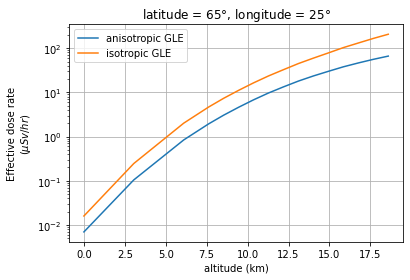

In [39]:
GLE_maps[1].query("latitude == 65").query("longitude == 25").plot("altitude (km)","edose",label="anisotropic GLE")
flat_GLE_maps[1].query("latitude == 65").query("longitude == 25").plot("altitude (km)","edose",ax=plt.gca(),label="isotropic GLE")

plt.title(r"latitude = 65$\degree$, longitude = 25$\degree$")

plt.ylabel(f"Effective dose rate\n($\mu Sv/hr$)")

plt.yscale("log")
plt.grid(True)

save_image_to_paper_dir("Effective_dose_altitude_dependence_OULU")

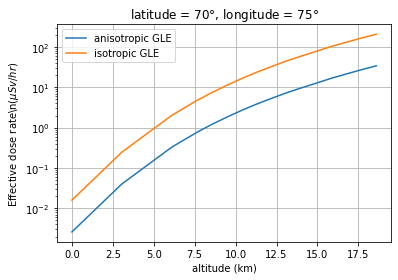

In [40]:
GLE_maps[1].query("latitude == 70").query("longitude == 75.0").plot("altitude (km)","edose",label="anisotropic GLE")
flat_GLE_maps[1].query("latitude == 70").query("longitude == 75.0").plot("altitude (km)","edose",ax=plt.gca(),label="isotropic GLE")

plt.title(r"latitude = 70$\degree$, longitude = 75$\degree$")

plt.ylabel(r"Effective dose rate\n($\mu Sv/hr$)")
plt.yscale("log")
plt.grid(True)

save_image_to_paper_dir("Effective_dose_altitude_dependence_OULU_shifted")

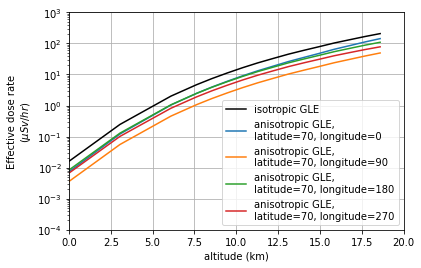

In [41]:
flat_GLE_maps[1].query("latitude == 65").query("longitude == 25").plot("altitude (km)","edose",ax=plt.gca(),
                                                                       label="isotropic GLE",color="black")

for coords in [[70,0],[70,90],[70,180],[70,270]]:
    GLE_maps[1].query(f"latitude == {coords[0]}").query(f"longitude == {coords[1]}").plot("altitude (km)","edose",ax=plt.gca(),
                                                                                          label=f"anisotropic GLE,\nlatitude={coords[0]}, longitude={coords[1]}")

#plt.title(r"latitude = 70$\degree$, longitude = 75$\degree$")

plt.ylabel(f"Effective dose rate\n($\mu Sv/hr$)")
plt.yscale("log")
plt.grid(True)

plt.xlim([0,20])
plt.ylim([1e-4,1e3])

plt.legend(fontsize=10)

save_image_to_paper_dir("Effective_dose_altitude_dependence_all",figure_number=5,additional_DF_to_save=GLE_maps[1])

In [42]:
one_kft_in_km = 0.3048

/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/dose_plotting.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_DF_to_Plot["SEU (Upsets/hr/Gb)"] = heatmap_DF_to_Plot["SEU"] * (60.0 * 60.0) * 1e9
/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/dose_plotting.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_DF_to_Plot["SEL (Latch-ups/hr/device)"] = heatmap_DF_to_Plot["SEL"] * (60.0 * 60.0)
/home/chrisswdavis/.local/lib/python3.8/site-packages/AniMAIRE/dose_p

(<AxesSubplot:title={'center':'52 kft'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e0b6228b0>)

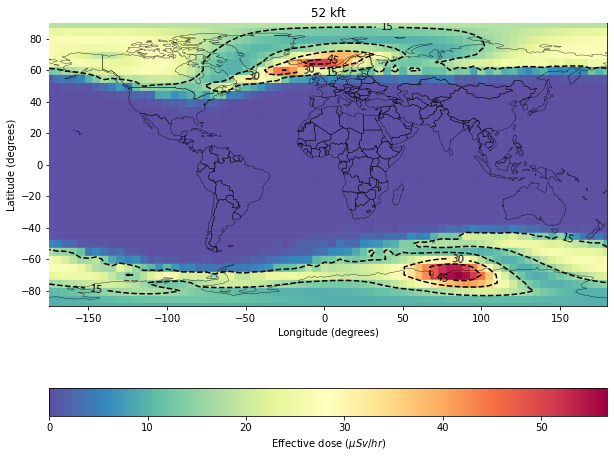

In [43]:
plot_GLE_map(GLE_maps[0].query(f"`altitude (km)` == {52 * one_kft_in_km}"),
             plot_title="52 kft",
             edgecolor=None)

In [44]:
add_dose_maps(cosmic_ray_initial_map_50kft_only,GLE_maps_50kft[1])

latitude  longitude  altitude (km)      edose      adose      dosee  \
0        -90.0        0.0          15.24  28.534584  22.077901  17.542841   
1        -90.0        5.0          15.24  28.534584  22.077901  17.542841   
2        -90.0       10.0          15.24  28.534584  22.077901  17.542841   
3        -90.0       15.0          15.24  28.534584  22.077901  17.542841   
4        -90.0       20.0          15.24  28.534584  22.077901  17.542841   
...        ...        ...            ...        ...        ...        ...   
2659      90.0      335.0          15.24  41.007211  31.858623  24.465057   
2660      90.0      340.0          15.24  41.007211  31.858623  24.465057   
2661      90.0      345.0          15.24  41.007211  31.858623  24.465057   
2662      90.0      350.0          15.24  41.007211  31.858623  24.465057   
2663      90.0      355.0          15.24  41.007211  31.858623  24.465057   

           tn1       tn2       tn3           SEU           SEL  \
0     6.376340  4.051660  2.771664  4.698170e-13  4.698170e-08   
1     6.376340  4.051660  2.771664  4.698170e-13  4.698170e-08   
2     6.376340  4.051660  2.771664  4.698170e-13  4.698170e-08   
3     6.376340  4.051660  2.771664  4.698170e-13  4.698170e-08   
4     6.376340  4.051660  2.771664  4.698170e-13  4.698170e-08   
...        ...       ...       ...           ...           ...   
2659  9.911208  6.284734  4.281495  6.931244e-13  6.931244e-08   
2660  9.911208  6.284734  4.281495  6.931244e-13  6.931244e-08   
2661  9.911208  6.284734  4.281495  6.931244e-13  6.931244e-08   
2662  9.911208  6.284734  4.281495  6.931244e-13  6.931244e-08   
2663  9.911208  6.284734  4.281495  6.931244e-13  6.931244e-08   

      longitudeTranslated                  datetime  
0                     0.0 2012-05-17 01:55:00+00:00  
1                     5.0 2012-05-17 01:55:00+00:00  
2                    10.0 2012-05-17 01:55:00+00:00  
3                    15.0 2012-05-17 01:55:00+00:00  
4                    20.0 2012-05-17 01:55:00+00:00  
...                   ...                       ...  
2659                -25.0 2012-05-17 01:55:00+00:00  
2660                -20.0 2012-05-17 01:55:00+00:00  
2661                -15.0 2012-05-17 01:55:00+00:00  
2662                -10.0 2012-05-17 01:55:00+00:00  
2663                 -5.0 2012-05-17 01:55:00+00:00  

[2664 rows x 13 columns]

In [45]:
cosmic_ray_initial_map.query("latitude == 0.0").query("longitude == 0.0")

latitude  longitude  altitude (km)     edose     adose     dosee  \
20736       0.0        0.0         0.0000  0.057256  0.058904  0.091687   
20737       0.0        0.0         3.0480  0.163799  0.163772  0.211406   
20738       0.0        0.0         6.0960  0.545144  0.519318  0.673055   
20739       0.0        0.0         7.6200  0.909868  0.883977  1.105321   
20740       0.0        0.0         8.5344  1.169941  1.067909  1.419299   
20741       0.0        0.0         9.4488  1.460939  1.305370  1.746989   
20742       0.0        0.0        10.3632  1.766104  1.545644  2.071498   
20743       0.0        0.0        11.2776  2.063346  1.772235  2.398063   
20744       0.0        0.0        12.1920  2.341674  1.971705  2.612617   
20745       0.0        0.0        13.1064  2.586813  2.134948  2.824216   
20746       0.0        0.0        14.0208  2.791438  2.263809  2.940773   
20747       0.0        0.0        14.9352  2.950217  2.329167  2.957416   
20748       0.0        0.0        15.8496  3.059026  2.352981  2.925520   
20749       0.0        0.0        16.7640  3.149394  2.370694  2.867652   
20750       0.0        0.0        17.6784  3.199262  2.365155  2.728264   
20751       0.0        0.0        18.5928  3.221403  2.288706  2.566420   

            tn1       tn2       tn3           SEU           SEL  \
20736  0.004109  0.002506  0.001745  2.949123e-16  2.949123e-11   
20737  0.027197  0.017647  0.012352  2.056424e-15  2.056424e-10   
20738  0.098739  0.064527  0.045445  7.452694e-15  7.452694e-10   
20739  0.155611  0.101474  0.071515  1.166129e-14  1.166129e-09   
20740  0.192196  0.125487  0.088571  1.439230e-14  1.439230e-09   
20741  0.230195  0.150119  0.106110  1.717744e-14  1.717744e-09   
20742  0.266543  0.173366  0.123026  1.979881e-14  1.979881e-09   
20743  0.298807  0.194419  0.138302  2.214449e-14  2.214449e-09   
20744  0.326734  0.212536  0.151300  2.415672e-14  2.415672e-09   
20745  0.349849  0.226434  0.161189  2.569761e-14  2.569761e-09   
20746  0.365276  0.236870  0.168627  2.683451e-14  2.683451e-09   
20747  0.374992  0.243294  0.173400  2.752141e-14  2.752141e-09   
20748  0.380007  0.246275  0.175979  2.780073e-14  2.780073e-09   
20749  0.381884  0.247236  0.176846  2.786008e-14  2.786008e-09   
20750  0.377660  0.243538  0.174045  2.741593e-14  2.741593e-09   
20751  0.370224  0.238930  0.170623  2.686069e-14  2.686069e-09   

                       datetime  
20736 2012-05-17 01:55:00+00:00  
20737 2012-05-17 01:55:00+00:00  
20738 2012-05-17 01:55:00+00:00  
20739 2012-05-17 01:55:00+00:00  
20740 2012-05-17 01:55:00+00:00  
20741 2012-05-17 01:55:00+00:00  
20742 2012-05-17 01:55:00+00:00  
20743 2012-05-17 01:55:00+00:00  
20744 2012-05-17 01:55:00+00:00  
20745 2012-05-17 01:55:00+00:00  
20746 2012-05-17 01:55:00+00:00  
20747 2012-05-17 01:55:00+00:00  
20748 2012-05-17 01:55:00+00:00  
20749 2012-05-17 01:55:00+00:00  
20750 2012-05-17 01:55:00+00:00  
20751 2012-05-17 01:55:00+00:00

In [46]:
cosmic_ray_initial_map["altitude (kft)"] = cosmic_ray_initial_map["altitude (km)"] / 0.3048

In [47]:
full_flat_DF = pd.concat(flat_GLE_maps).reset_index()
full_flat_DF["altitude (kft)"] = full_flat_DF["altitude (km)"] / 0.3048
full_flat_DF.columns

Index(['level_0', 'level_1', 'latitude', 'longitude', 'altitude (km)', 'edose',
       'adose', 'dosee', 'tn1', 'tn2', 'tn3', 'SEU', 'SEL', 'datetime',
       'altitude (kft)'],
      dtype='object')

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


(<AxesSubplot:title={'center':'Anisotropic GLE Spectra only\naltitude = 50 kft, date and time = 2012-05-17 01:55:00+00:00'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e3cc66a00>)

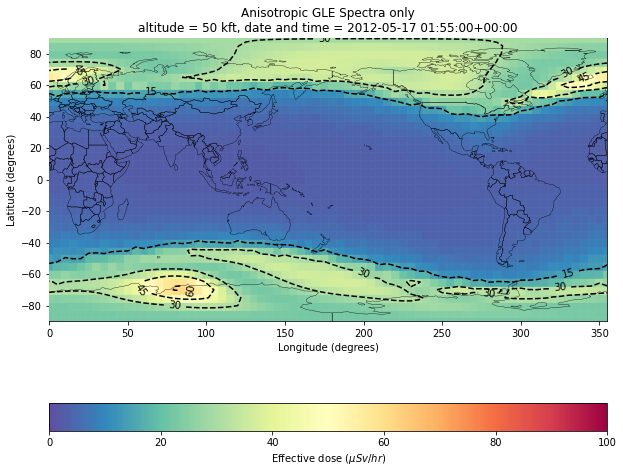

In [48]:
plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_50kft_only,GLE_maps_50kft[0]),
                plot_title=f"Anisotropic GLE Spectra only\naltitude = 50 kft, date and time = {Mishev_params_for_event.datetime.iloc[0]}",
                edgecolor=None,
                hue_range=(0,100),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                plot_longitude_east=True)



/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


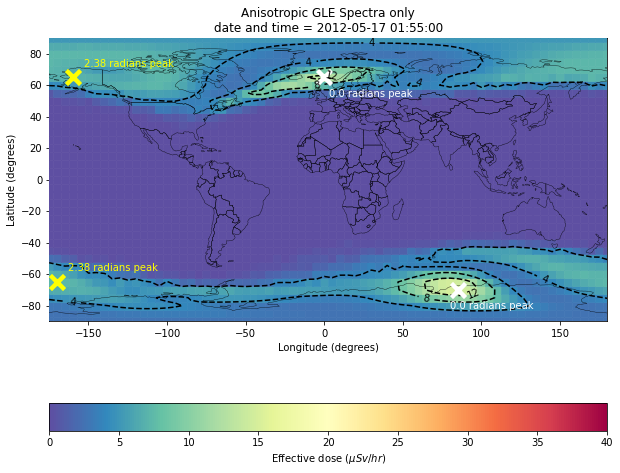

In [49]:
plot_GLE_map(GLE_maps_39kft[0],
                plot_title=f"Anisotropic GLE Spectra only\ndate and time = {Mishev_params_for_event.datetime.iloc[0].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                plot_longitude_east=False)

plt.scatter(north_hemisphere_max_weight_1st_peak["initialLongitudeTranslated"],
            north_hemisphere_max_weight_1st_peak["initialLatitude"],
            zorder=1000,marker="x",color="white",s=10,linewidth=20)
plt.text(s="0.0 radians peak",
         x=north_hemisphere_max_weight_1st_peak["initialLongitudeTranslated"] + 3,
         y=north_hemisphere_max_weight_1st_peak["initialLatitude"] - 7,
         color="white",
         verticalalignment="top",
         zorder=10000)

plt.scatter(south_hemisphere_max_weight_1st_peak["initialLongitudeTranslated"],
            south_hemisphere_max_weight_1st_peak["initialLatitude"],
            zorder=1000,marker="x",color="white",s=10,linewidth=20)
plt.text(s="0.0 radians peak",
         x=south_hemisphere_max_weight_1st_peak["initialLongitudeTranslated"] - 5,
         y=south_hemisphere_max_weight_1st_peak["initialLatitude"] - 7,
         color="white",
         verticalalignment="top",
         zorder=10000)

plt.scatter(north_hemisphere_max_weight_2nd_peak["initialLongitudeTranslated"],
            north_hemisphere_max_weight_2nd_peak["initialLatitude"],
            zorder=1000,marker="x",color="yellow",s=10,linewidth=20)
plt.text(s="2.38 radians peak",
         x=north_hemisphere_max_weight_2nd_peak["initialLongitudeTranslated"] + 7,
         y=north_hemisphere_max_weight_2nd_peak["initialLatitude"] + 7,
         color="yellow",
         zorder=10000)

plt.scatter(south_hemisphere_max_weight_2nd_peak["initialLongitudeTranslated"],
            south_hemisphere_max_weight_2nd_peak["initialLatitude"],
            zorder=1000,marker="x",color="yellow",s=10,linewidth=20)
plt.text(s="2.38 radians peak",
         x=south_hemisphere_max_weight_2nd_peak["initialLongitudeTranslated"] + 7,
         y=south_hemisphere_max_weight_2nd_peak["initialLatitude"] + 7,
         color="yellow",
         zorder=10000)

save_image_to_paper_dir("GLE_39kft_only",figure_number=3,additional_DF_to_save=GLE_maps_39kft[0])

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


Mishev comparison plots:


/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


(<AxesSubplot:title={'center':'Anisotropic GLE Spectra only\ndate and time = 2012-05-17 02:00:00+00:00'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e38f3b2e0>)

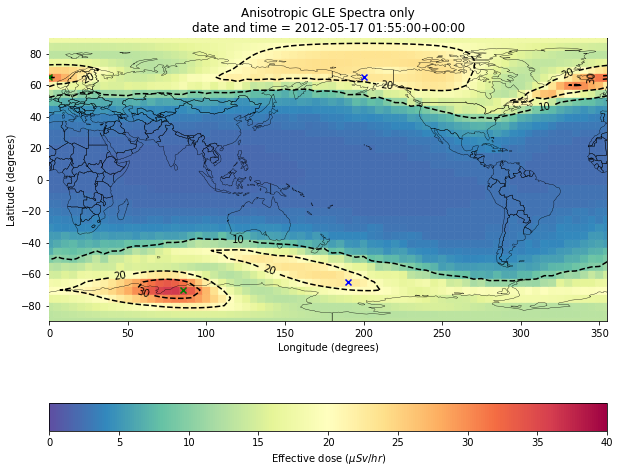

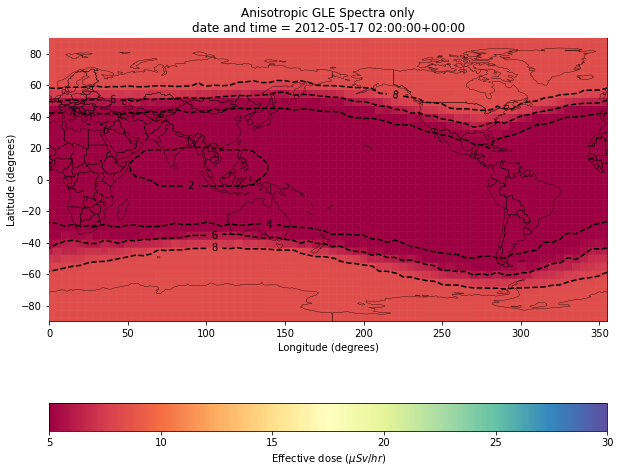

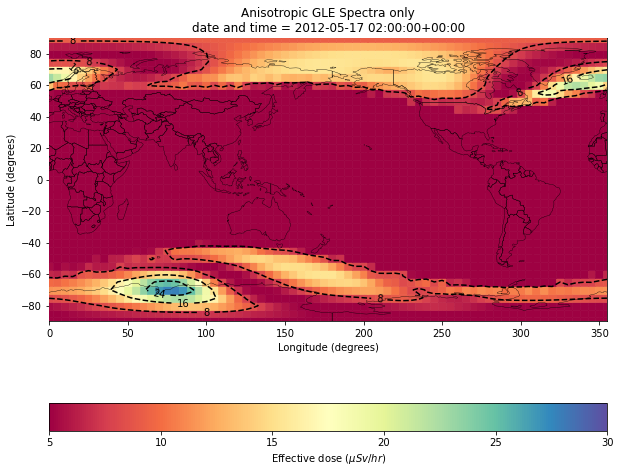

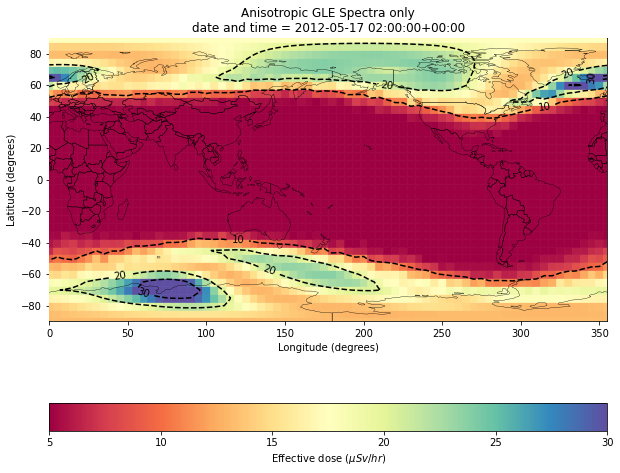

In [50]:


plt.figure()

plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_39kft_only,GLE_maps_39kft[1]),
                plot_title=f"Anisotropic GLE Spectra only\ndate and time = {Mishev_params_for_event.datetime.iloc[0]}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                plot_longitude_east=True)

plt.scatter(north_hemisphere_max_weight_1st_peak["initialLongitude"],
            north_hemisphere_max_weight_1st_peak["initialLatitude"],
            zorder=1000,marker="x",color="green")

plt.scatter(south_hemisphere_max_weight_1st_peak["initialLongitude"],
            south_hemisphere_max_weight_1st_peak["initialLatitude"],
            zorder=1000,marker="x",color="green")

plt.scatter(north_hemisphere_max_weight_2nd_peak["initialLongitude"],
            north_hemisphere_max_weight_2nd_peak["initialLatitude"],
            zorder=1000,marker="x",color="blue")

plt.scatter(south_hemisphere_max_weight_2nd_peak["initialLongitude"],
            south_hemisphere_max_weight_2nd_peak["initialLatitude"],
            zorder=1000,marker="x",color="blue")

print("Mishev comparison plots:")

plt.figure()

plot_GLE_map(cosmic_ray_initial_map_39kft_only,
                plot_title=f"Anisotropic GLE Spectra only\ndate and time = {Mishev_params_for_event.datetime.iloc[1]}",
                edgecolor=None,
                hue_range=(5.0,30),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral",
                plot_longitude_east=True)

plt.figure()

plot_GLE_map(GLE_maps_39kft[1],
                plot_title=f"Anisotropic GLE Spectra only\ndate and time = {Mishev_params_for_event.datetime.iloc[1]}",
                edgecolor=None,
                hue_range=(5.0,30),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral",
                plot_longitude_east=True)

plt.figure()

plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_39kft_only,GLE_maps_39kft[1]),
                plot_title=f"Anisotropic GLE Spectra only\ndate and time = {Mishev_params_for_event.datetime.iloc[1]}",
                edgecolor=None,
                hue_range=(5.0,30),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral",
                plot_longitude_east=True)

In [51]:
GLE_map_to_compare = GLE_maps_39kft[1].copy().sort_values(by=["latitude","longitude"])
GLE_map_to_compare["edose"].iloc[1:].iloc[::3] = GLE_map_to_compare.iloc[:].iloc[::3]["edose"]
GLE_map_to_compare["edose"].iloc[2:].iloc[::3] = GLE_map_to_compare.iloc[:].iloc[::3]["edose"]
GLE_map_to_compare

latitude  longitude  altitude (km)     edose     adose     dosee  \
0        -90.0        0.0          11.89  4.842460  4.724780  2.847633   
1        -90.0        5.0          11.89  4.842460  4.724780  2.847633   
2        -90.0       10.0          11.89  4.842460  4.724780  2.847633   
3        -90.0       15.0          11.89  4.842460  4.724780  2.847633   
4        -90.0       20.0          11.89  4.842460  4.724780  2.847633   
...        ...        ...            ...       ...       ...       ...   
2659      90.0      335.0          11.89  9.219594  8.920719  5.407402   
2660      90.0      340.0          11.89  9.219594  8.920719  5.407402   
2661      90.0      345.0          11.89  9.219594  8.920719  5.407402   
2662      90.0      350.0          11.89  9.219594  8.920719  5.407402   
2663      90.0      355.0          11.89  9.219594  8.920719  5.407402   

           tn1       tn2       tn3           SEU           SEL  \
0     2.006422  1.286222  0.874563  1.286222e-13  1.286222e-08   
1     2.006422  1.286222  0.874563  1.286222e-13  1.286222e-08   
2     2.006422  1.286222  0.874563  1.286222e-13  1.286222e-08   
3     2.006422  1.286222  0.874563  1.286222e-13  1.286222e-08   
4     2.006422  1.286222  0.874563  1.286222e-13  1.286222e-08   
...        ...       ...       ...           ...           ...   
2659  3.771349  2.418613  1.646199  2.418613e-13  2.418613e-08   
2660  3.771349  2.418613  1.646199  2.418613e-13  2.418613e-08   
2661  3.771349  2.418613  1.646199  2.418613e-13  2.418613e-08   
2662  3.771349  2.418613  1.646199  2.418613e-13  2.418613e-08   
2663  3.771349  2.418613  1.646199  2.418613e-13  2.418613e-08   

      longitudeTranslated                  datetime  SEU (Upsets/hr/Gb)  \
0                     0.0 2012-05-17 02:00:00+00:00            0.463040   
1                     5.0 2012-05-17 02:00:00+00:00            0.463040   
2                    10.0 2012-05-17 02:00:00+00:00            0.463040   
3                    15.0 2012-05-17 02:00:00+00:00            0.463040   
4                    20.0 2012-05-17 02:00:00+00:00            0.463040   
...                   ...                       ...                 ...   
2659                335.0 2012-05-17 02:00:00+00:00            0.870701   
2660                340.0 2012-05-17 02:00:00+00:00            0.870701   
2661                345.0 2012-05-17 02:00:00+00:00            0.870701   
2662                350.0 2012-05-17 02:00:00+00:00            0.870701   
2663                355.0 2012-05-17 02:00:00+00:00            0.870701   

      SEL (Latch-ups/hr/device)  
0                      0.000046  
1                      0.000046  
2                      0.000046  
3                      0.000046  
4                      0.000046  
...                         ...  
2659                   0.000087  
2660                   0.000087  
2661                   0.000087  
2662                   0.000087  
2663                   0.000087  

[2664 rows x 15 columns]

In [52]:
GLE_map_to_compare_latitude_smooth = GLE_maps_39kft[1].copy().sort_values(by=["longitude","latitude"])
list_of_sub_DFs = []

for longitude in GLE_map_to_compare_latitude_smooth["longitude"]:
    sub_DF = GLE_map_to_compare_latitude_smooth.query(f"longitude == {longitude}").iloc[:-1]
    sub_DF["edose"].iloc[1:].iloc[::3] = sub_DF.iloc[:].iloc[::3]["edose"].to_numpy()
    sub_DF["edose"].iloc[2:].iloc[::3] = sub_DF.iloc[:].iloc[::3]["edose"].to_numpy()
    list_of_sub_DFs.append(sub_DF)

GLE_map_to_compare_latitude_smooth = pd.concat(list_of_sub_DFs)

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


(<AxesSubplot:title={'center':'Anisotropic GLE Spectra only\naltitude = 39 kft, date and time = 2012-05-17 02:00:00+00:00'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e0da31760>)

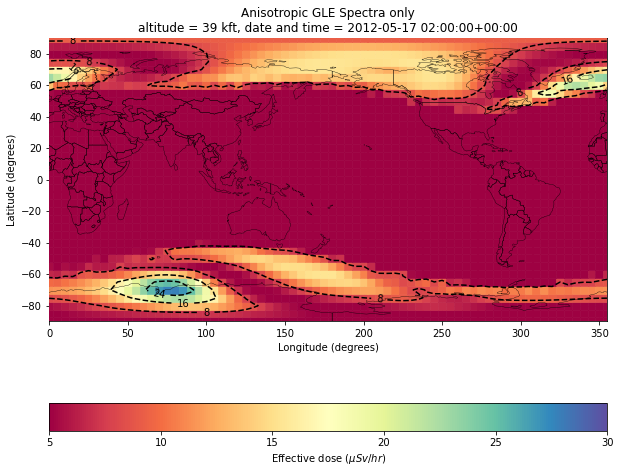

In [53]:
plot_GLE_map(GLE_maps_39kft[1],
                plot_title=f"Anisotropic GLE Spectra only\naltitude = 39 kft, date and time = {Mishev_params_for_event.datetime.iloc[1]}",
                edgecolor=None,
                hue_range=(5.0,30),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral",
                plot_longitude_east=True)

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


(<AxesSubplot:title={'center':'Anisotropic GLE Spectra only\naltitude = 39 kft, date and time = 2012-05-17 02:00:00+00:00'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e0e73afd0>)

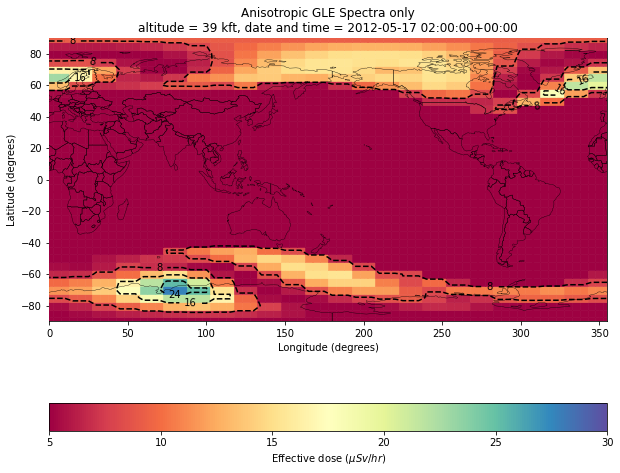

In [54]:
plot_GLE_map(GLE_map_to_compare,
                plot_title=f"Anisotropic GLE Spectra only\naltitude = 39 kft, date and time = {Mishev_params_for_event.datetime.iloc[1]}",
                edgecolor=None,
                hue_range=(5.0,30),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral",
                plot_longitude_east=True)

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


(<AxesSubplot:title={'center':'Anisotropic GLE Spectra only\naltitude = 39 kft, date and time = 2012-05-17 02:00:00+00:00'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e0e59c520>)

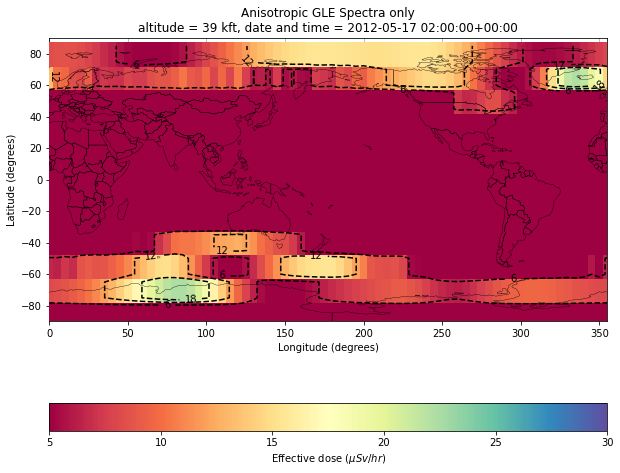

In [55]:
plot_GLE_map(GLE_map_to_compare_latitude_smooth.sort_values(by=["latitude","longitude"]),
                plot_title=f"Anisotropic GLE Spectra only\naltitude = 39 kft, date and time = {Mishev_params_for_event.datetime.iloc[1]}",
                edgecolor=None,
                hue_range=(5.0,30),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral",
                plot_longitude_east=True)

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


(<AxesSubplot:title={'center':'Anisotropic GLE Spectra only\naltitude = 50 kft, date and time = 2012-05-17 01:55:00+00:00'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e0cf24a60>)

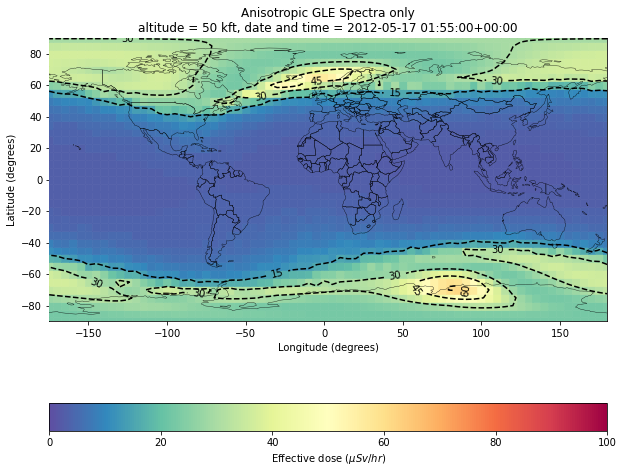

In [56]:
plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_50kft_only,GLE_maps_50kft[0]),
                plot_title=f"Anisotropic GLE Spectra only\naltitude = 50 kft, date and time = {Mishev_params_for_event.datetime.iloc[0]}",
                edgecolor=None,
                hue_range=(0,100),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r")

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel

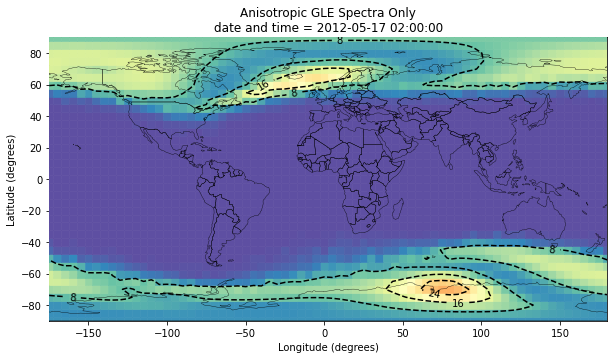

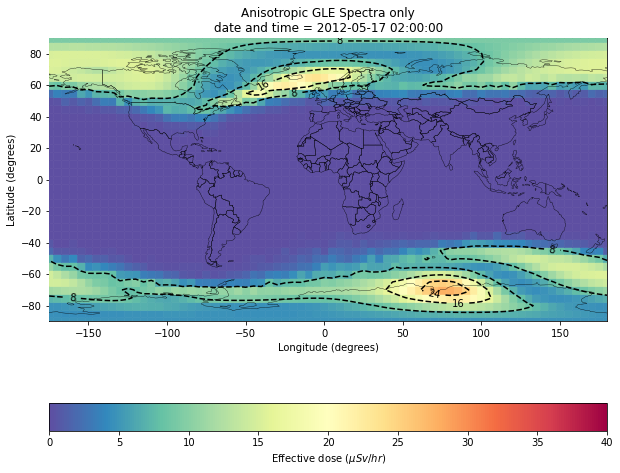

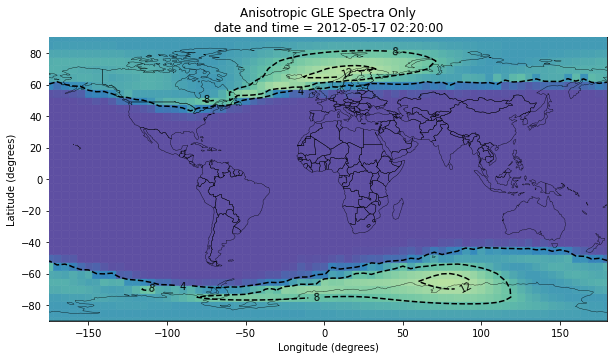

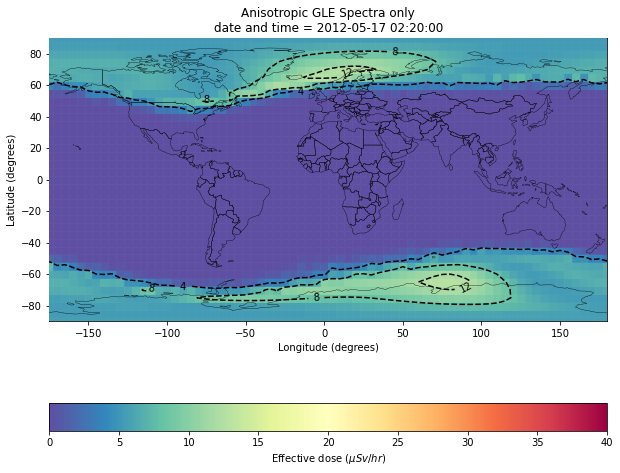

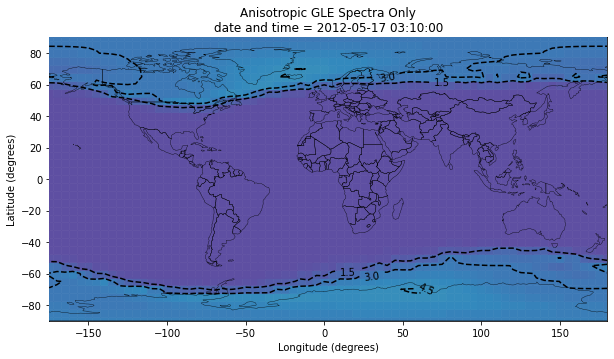

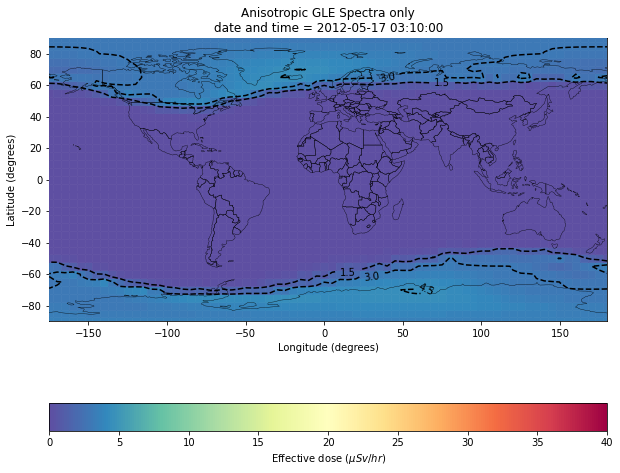

In [57]:
for time_index in [1,5,15]:

    plt.figure()

    #plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_50kft_only,GLE_maps_50kft[time_index]),
    plot_GLE_map(GLE_maps_39kft[time_index],
                plot_title=f"Anisotropic GLE Spectra Only\ndate and time = {Mishev_params_for_event.datetime.iloc[time_index].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                plot_colorbar=False)
    
    save_image_to_paper_dir(f"Ani_GLE_only_timestamp{time_index}",save_legend_separately=False,figure_number=4,additional_DF_to_save=GLE_maps_39kft[time_index])

    plt.figure()

    plot_GLE_map(GLE_maps_39kft[time_index],
                plot_title=f"Anisotropic GLE Spectra only\ndate and time = {Mishev_params_for_event.datetime.iloc[time_index].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r")
    
    save_image_to_paper_dir(f"Ani_GLE_only_timestamp{time_index}_with_legend",save_legend_separately=False,figure_number=4,additional_DF_to_save=GLE_maps_39kft[time_index])

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel

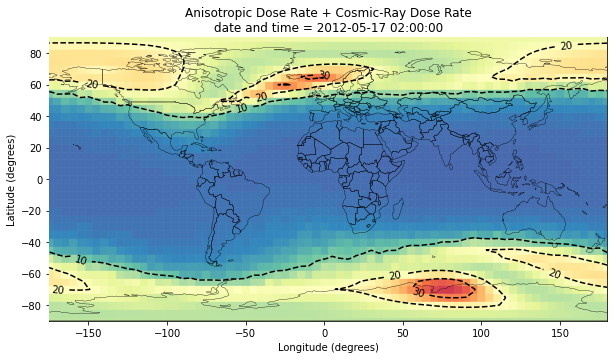

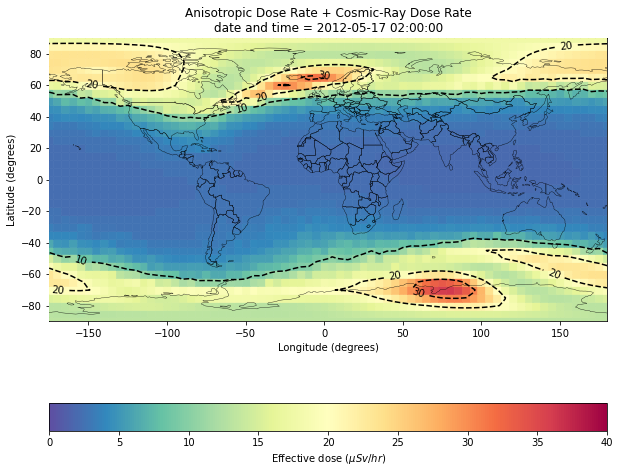

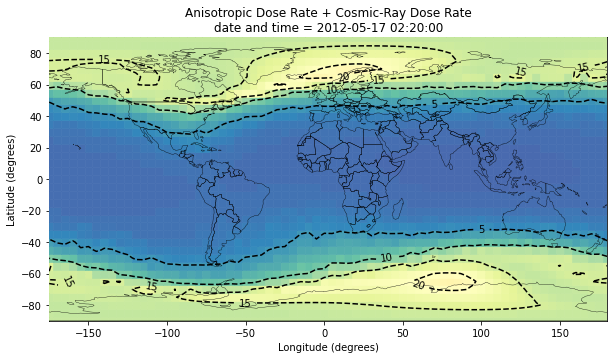

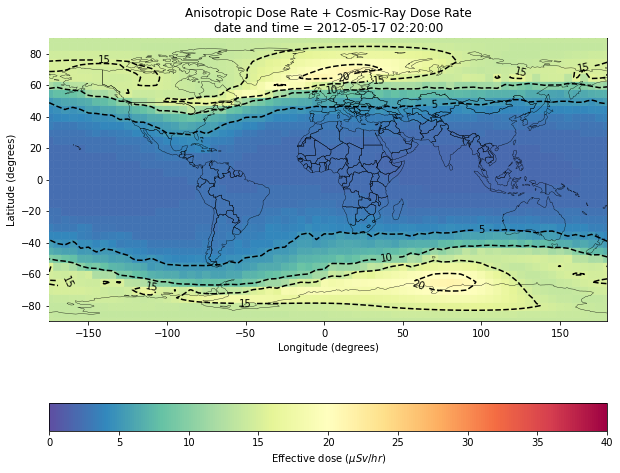

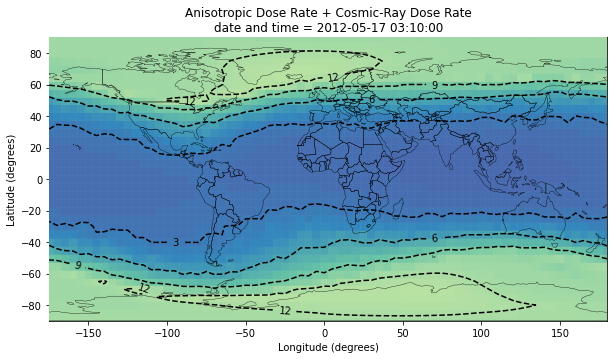

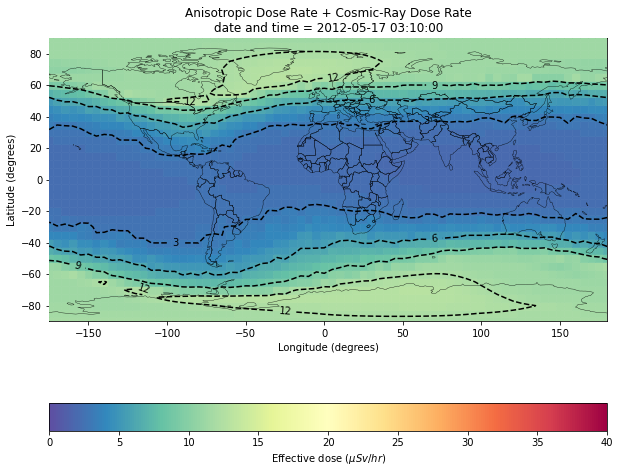

In [58]:
for time_index in [1,5,15]:

    plt.figure()

    plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_39kft_only,
                               GLE_maps_39kft[time_index].drop(['SEU (Upsets/hr/Gb)', 'SEL (Latch-ups/hr/device)'],axis=1)),
                plot_title=f"Anisotropic Dose Rate + Cosmic-Ray Dose Rate\ndate and time = {Mishev_params_for_event.datetime.iloc[time_index].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                plot_colorbar=False)
    
    save_image_to_paper_dir(f"total_dose_timestamp{time_index}",save_legend_separately=False,figure_number=4,additional_DF_to_save=add_dose_maps(cosmic_ray_initial_map_39kft_only,
                                                                                                                                    GLE_maps_39kft[time_index].drop(['SEU (Upsets/hr/Gb)', 'SEL (Latch-ups/hr/device)'],axis=1)))

    plt.figure()

    plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_39kft_only,
                               GLE_maps_39kft[time_index].drop(['SEU (Upsets/hr/Gb)', 'SEL (Latch-ups/hr/device)'],axis=1)),
                plot_title=f"Anisotropic Dose Rate + Cosmic-Ray Dose Rate\ndate and time = {Mishev_params_for_event.datetime.iloc[time_index].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r")
    
    save_image_to_paper_dir(f"total_dose_timestamp{time_index}_with_legend",save_legend_separately=False,figure_number=4,additional_DF_to_save=add_dose_maps(cosmic_ray_initial_map_39kft_only,
                                                                                                                                    GLE_maps_39kft[time_index].drop(['SEU (Upsets/hr/Gb)', 'SEL (Latch-ups/hr/device)'],axis=1)))

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_colorbar'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_lo

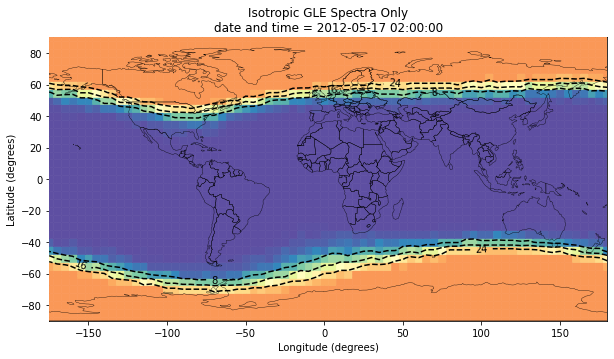

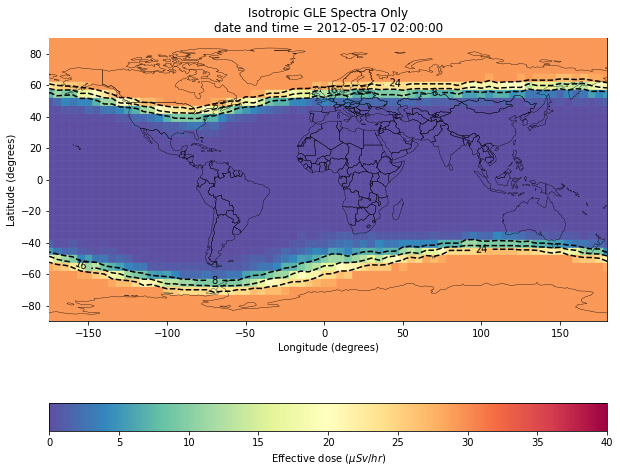

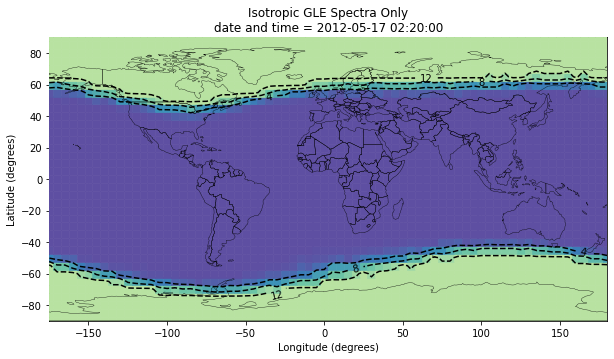

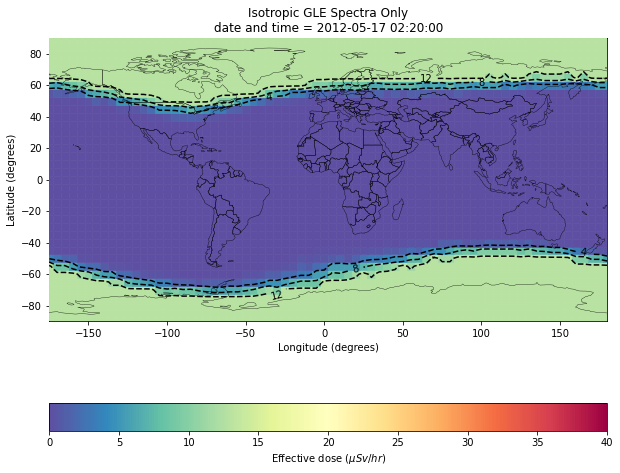

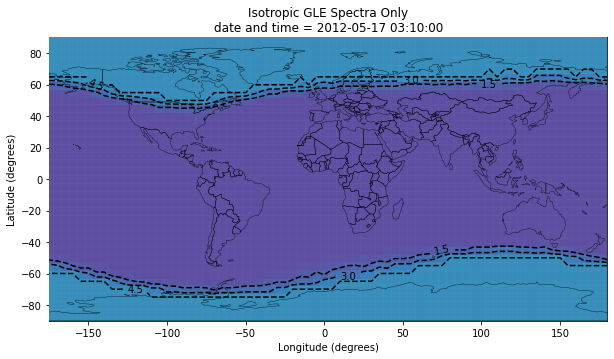

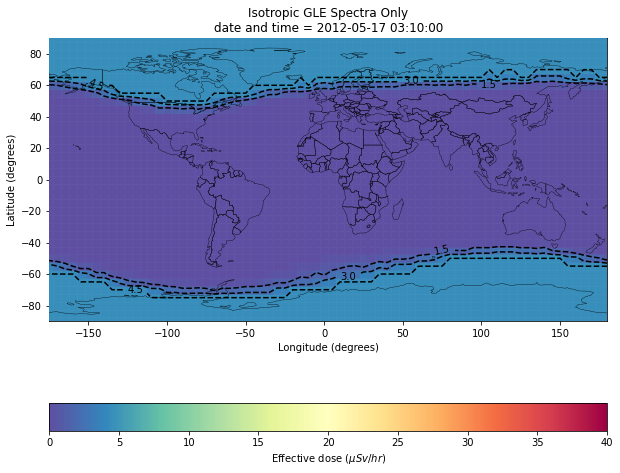

In [59]:
for time_index in [1,5,15]:

    plt.figure()

    #plot_GLE_map(add_dose_maps(cosmic_ray_initial_map_50kft_only,flat_GLE_maps_50kft[time_index]),
    plot_GLE_map(flat_GLE_maps_39kft[time_index],
                plot_title=f"Isotropic GLE Spectra Only\ndate and time = {Mishev_params_for_event.datetime.iloc[time_index].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                plot_colorbar=False)
    
    save_image_to_paper_dir(f"Flat_GLE_only_timestamp{time_index}",save_legend_separately=False,figure_number=4,additional_DF_to_save=flat_GLE_maps_39kft[time_index])

    # plt.figure()
    # colorbar = add_colorbar_to_plot(hue_range=(0,100), palette="Spectral_r", legend_label=r"Effective dose ($\mu Sv / hr$)", scatterPlotAxis=plt.gca())
    # colorbar.ax.figure.savefig(f"colorbar_GLE_only_timestamp{time_index}.png", dpi=300)
    # #save_image_to_paper_dir(f"Flat_GLE_only_timestamp{time_index}_legend_only")

    plt.figure()

    plot_GLE_map(flat_GLE_maps_39kft[time_index],
                plot_title=f"Isotropic GLE Spectra Only\ndate and time = {Mishev_params_for_event.datetime.iloc[time_index].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                plot_colorbar=True)
    
    save_image_to_paper_dir(f"Flat_GLE_only_timestamp{time_index}_with_legend",save_legend_separately=False,figure_number=4,additional_DF_to_save=flat_GLE_maps_39kft[time_index])

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


(<AxesSubplot:title={'center':'Galactic Cosmic-Ray Spectra Only\naltitude = 50 kft, date and time = 2012-05-17 01:55:00'}, xlabel='Longitude (degrees)', ylabel='Latitude (degrees)'>,
 <matplotlib.colorbar.Colorbar at 0x7f0e0d511430>)

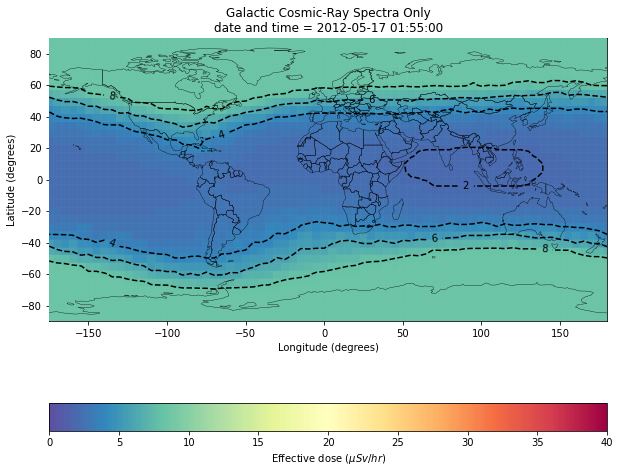

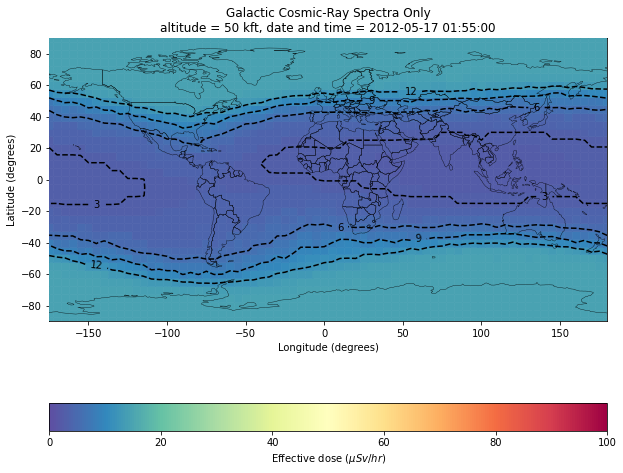

In [60]:
plot_GLE_map(cosmic_ray_initial_map_39kft_only,
                plot_title=f"Galactic Cosmic-Ray Spectra Only\ndate and time = {Mishev_params_for_event.datetime.iloc[0].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r")

save_image_to_paper_dir(f"cosmic_ray_only",figure_number=3,additional_DF_to_save=cosmic_ray_initial_map_39kft_only)

plt.figure()

plot_GLE_map(cosmic_ray_initial_map_50kft_only,
                plot_title=f"Galactic Cosmic-Ray Spectra Only\naltitude = 50 kft, date and time = {Mishev_params_for_event.datetime.iloc[0].strftime('%Y-%m-%d %H:%M:%S')}",
                edgecolor=None,
                hue_range=(0,100),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r")

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


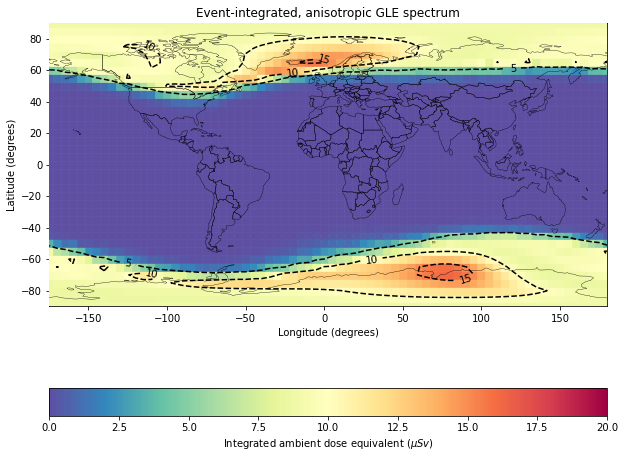

In [61]:
plot_GLE_map(event_integrated_dose_map_39kft,
                plot_title=f"Event-integrated, anisotropic GLE spectrum",
                edgecolor=None,
                hue_range=(0,20),
                legend_label=r"Integrated ambient dose equivalent ($\mu Sv$)",
                palette="Spectral_r")

save_image_to_paper_dir(f"event_integrated_GLE_only",figure_number=6,additional_DF_to_save=event_integrated_dose_map_39kft)

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


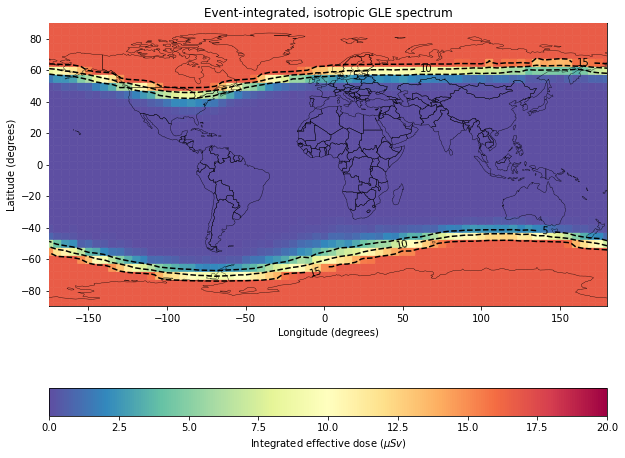

In [62]:
plot_GLE_map(event_integrated_flat_dose_map_39kft,
                plot_title=f"Event-integrated, isotropic GLE spectrum",
                edgecolor=None,
                hue_range=(0,20),
                legend_label=r"Integrated effective dose ($\mu Sv$)",
                palette="Spectral_r")

save_image_to_paper_dir(f"event_integrated_flat_GLE_only",figure_number=6,additional_DF_to_save=event_integrated_flat_dose_map_39kft)

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


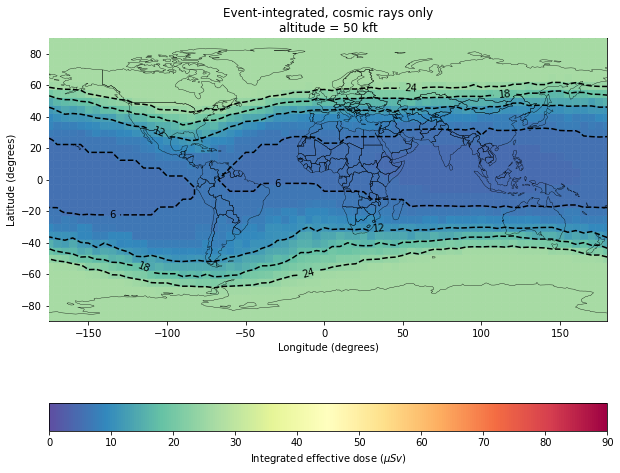

In [63]:
plot_GLE_map(event_integrated_cosmic_rays,
                plot_title=f"Event-integrated, cosmic rays only\naltitude = 50 kft",
                edgecolor=None,
                hue_range=(0,90),
                legend_label=r"Integrated effective dose ($\mu Sv$)",
                palette="Spectral_r")

save_image_to_paper_dir(f"event_integrated_cosmic_rays_only")

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


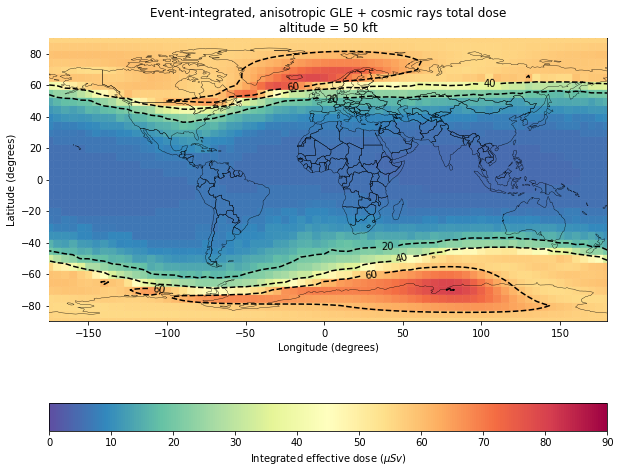

In [64]:
plot_GLE_map(add_dose_maps(event_integrated_cosmic_rays,event_integrated_dose_map_50kft),
                plot_title=f"Event-integrated, anisotropic GLE + cosmic rays total dose\naltitude = 50 kft",
                edgecolor=None,
                hue_range=(0,90),
                legend_label=r"Integrated effective dose ($\mu Sv$)",
                palette="Spectral_r")

save_image_to_paper_dir(f"event_integrated_total_dose")

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


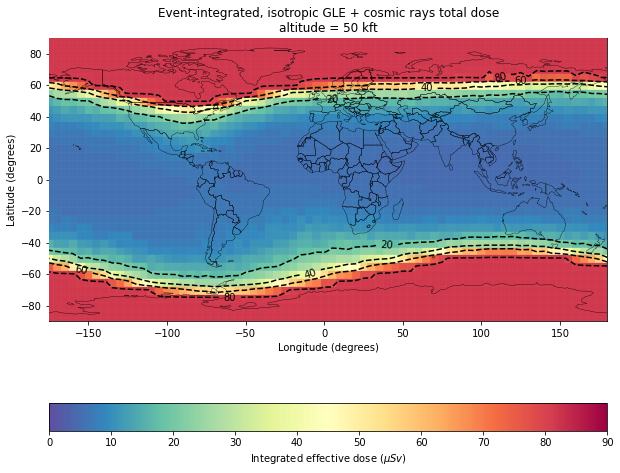

In [65]:
plot_GLE_map(add_dose_maps(event_integrated_cosmic_rays,event_integrated_flat_dose_map_50kft),
                plot_title=f"Event-integrated, isotropic GLE + cosmic rays total dose\naltitude = 50 kft",
                edgecolor=None,
                hue_range=(0,90),
                legend_label=r"Integrated effective dose ($\mu Sv$)",
                palette="Spectral_r")

save_image_to_paper_dir(f"event_integrated_flat_total_dose")

In [66]:
effective_dose_DF_Mishev = pd.read_html("MishevGLE71fittingPaper.html")[2]
effective_dose_DF_Mishev

Integration interval/altitude Unnamed: 1_level_0 Unnamed: 2_level_0  \
                       (UT/kft)                 10                 20   
0                          GCRs               0.24                2.5   
1                   01:50–01:55               0.36                5.1   
2                   01:55–02:00               0.46               11.0   
3                   02:10–02:15               0.34                4.8   
4                   02:25–02:30               0.29                4.3   
5                   02:40–02:45               0.27                3.4   
6                   02:55–03:00               0.27                3.1   
7                   03:10–03:15               0.26                2.8   
8                   03:25–03:30               0.26                2.5   
9                   03:40–03:45               0.25                2.0   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                  25                 30                 35                 40   
0                4.0                5.7                8.0               10.0   
1                9.2               14.0               20.0               27.1   
2               17.5               22.0               29.9               41.0   
3                8.5               12.8               20.2               27.0   
4                7.4               11.0               15.7               20.0   
5                6.2               10.0               13.3               17.1   
6                6.0                9.5               12.7               16.0   
7                5.3                8.8               12.0               15.3   
8                5.0                8.3               11.6               14.5   
9                4.7                7.9               11.1               14.0   

  Unnamed: 7_level_0  
                  50  
0               14.4  
1               39.4  
2               59.4  
3               38.8  
4               27.9  
5               23.2  
6               22.0  
7               20.6  
8               20.0  
9               19.5

In [67]:
cosmic_ray_initial_map
cosmic_ray_initial_map["altitude (kft)"] = cosmic_ray_initial_map["altitude (km)"] / one_kft_in_km
cosmic_ray_initial_map_edose_DF = cosmic_ray_initial_map.query("latitude == 90.0").query("longitude == 0.0")[["altitude (kft)","edose","datetime"]].pivot("datetime","altitude (kft)")["edose"]
cosmic_ray_initial_map_edose_DF


altitude (kft)                 0.0       10.0     20.0      25.0      28.0  \
datetime                                                                     
2012-05-17 01:55:00+00:00  0.070523  0.296067  1.32399  2.457785  3.381634   

altitude (kft)                 31.0      34.0     37.0      40.0       43.0  \
datetime                                                                      
2012-05-17 01:55:00+00:00  4.506462  5.815994  7.28028  8.855553  10.512935   

altitude (kft)                  46.0       49.0     52.0       55.0  \
datetime                                                              
2012-05-17 01:55:00+00:00  12.201914  13.900323  15.6368  17.382341   

altitude (kft)                  58.0       61.0  
datetime                                         
2012-05-17 01:55:00+00:00  19.109438  20.781623

In [68]:
flat_GLE_maps_concatted = pd.concat(flat_GLE_maps)
flat_GLE_maps_concatted["altitude (kft)"] = flat_GLE_maps_concatted["altitude (km)"] / one_kft_in_km
flat_adose_DF = flat_GLE_maps_concatted.query("latitude == 90.0").query("longitude == 0.0")[["altitude (kft)","adose","datetime"]].pivot("datetime","altitude (kft)")["adose"]
flat_edose_DF = flat_GLE_maps_concatted.query("latitude == 90.0").query("longitude == 0.0")[["altitude (kft)","edose","datetime"]].pivot("datetime","altitude (kft)")["edose"]
flat_edose_DF

altitude (kft)                 0.0       10.0      20.0      25.0      28.0  \
datetime                                                                      
2012-05-17 01:55:00+00:00  0.007863  0.125717  1.059479  2.488957  3.950766   
2012-05-17 02:00:00+00:00  0.015991  0.246285  2.013385  4.671378  7.351596   
2012-05-17 02:05:00+00:00  0.007224  0.124144  1.104871  2.639621  4.233087   
2012-05-17 02:10:00+00:00  0.007035  0.121253  1.081394  2.585037  4.147087   
2012-05-17 02:15:00+00:00  0.006428  0.111325  0.996456  2.384330  3.825603   
2012-05-17 02:20:00+00:00  0.004793  0.085275  0.778392  1.872787  3.010309   
2012-05-17 02:25:00+00:00  0.004891  0.085851  0.776746  1.864260  2.992029   
2012-05-17 02:30:00+00:00  0.003172  0.057468  0.533360  1.290088  2.074942   
2012-05-17 02:35:00+00:00  0.002769  0.050284  0.467862  1.132602  1.821927   
2012-05-17 02:40:00+00:00  0.002181  0.039680  0.369864  0.895918  1.441310   
2012-05-17 02:45:00+00:00  0.002098  0.038266  0.357541  0.866739  1.394674   
2012-05-17 02:50:00+00:00  0.002044  0.037372  0.349848  0.848608  1.365753   
2012-05-17 02:55:00+00:00  0.001866  0.034301  0.322525  0.783429  1.261454   
2012-05-17 03:00:00+00:00  0.001790  0.032884  0.309046  0.750577  1.208471   
2012-05-17 03:05:00+00:00  0.001681  0.030907  0.290846  0.706703  1.137912   
2012-05-17 03:10:00+00:00  0.001563  0.028815  0.271806  0.660961  1.064503   
2012-05-17 03:15:00+00:00  0.001442  0.026678  0.252468  0.614584  0.990163   
2012-05-17 03:20:00+00:00  0.001289  0.023950  0.227381  0.554090  0.893008   
2012-05-17 03:25:00+00:00  0.001277  0.023717  0.225173  0.548710  0.884338   
2012-05-17 03:30:00+00:00  0.001300  0.024058  0.227672  0.554223  0.892915   
2012-05-17 03:35:00+00:00  0.001167  0.021826  0.208486  0.509061  0.820967   
2012-05-17 03:40:00+00:00  0.001039  0.019673  0.190013  0.465668  0.751854   

altitude (kft)                  31.0       34.0       37.0       40.0  \
datetime                                                                
2012-05-17 01:55:00+00:00   6.028130   8.998404  13.035197  18.239557   
2012-05-17 02:00:00+00:00  11.127558  16.447463  23.593092  32.697323   
2012-05-17 02:05:00+00:00   6.517391   9.835266  14.409924  20.439092   
2012-05-17 02:10:00+00:00   6.387013   9.642625  14.134050  20.058715   
2012-05-17 02:15:00+00:00   5.892456   8.892387  13.028639  18.486196   
2012-05-17 02:20:00+00:00   4.643827   7.008366  10.267788  14.581844   
2012-05-17 02:25:00+00:00   4.609608   6.944340  10.154914  14.388911   
2012-05-17 02:30:00+00:00   3.203023   4.817292   7.029809   9.945418   
2012-05-17 02:35:00+00:00   2.812919   4.228749   6.167823   8.721273   
2012-05-17 02:40:00+00:00   2.225503   3.344267   4.875411   6.890191   
2012-05-17 02:45:00+00:00   2.153961   3.236121   4.716572   6.663950   
2012-05-17 02:50:00+00:00   2.109677   3.169224   4.618363   6.524130   
2012-05-17 02:55:00+00:00   1.949451   2.928166   4.266228   6.025444   
2012-05-17 03:00:00+00:00   1.867455   2.804858   4.086368   5.771057   
2012-05-17 03:05:00+00:00   1.758584   2.640499   3.845501   5.428559   
2012-05-17 03:10:00+00:00   1.645517   2.470234   3.596613   5.075686   
2012-05-17 03:15:00+00:00   1.531130   2.298252   3.345618   4.720475   
2012-05-17 03:20:00+00:00   1.381363   2.073180   3.017395   4.256375   
2012-05-17 03:25:00+00:00   1.367951   2.053052   2.988100   4.215051   
2012-05-17 03:30:00+00:00   1.380751   2.072531   3.017030   4.256857   
2012-05-17 03:35:00+00:00   1.270741   1.906570   2.773701   3.910485   
2012-05-17 03:40:00+00:00   1.165140   1.746832   2.538786   3.574558   

altitude (kft)                  43.0       46.0       49.0        52.0  \
datetime                                                                 
2012-05-17 01:55:00+00:00  25.407312  34.044750  45.108925   60.203150   
2012-05-17 02:00:00+00:00  45.005932  59.701609  78.248293  103.178658   
2012-05-17 02:05:00+00:00  29.090027  39.744218  54.21

In [69]:
total_flat_GLE_maps_concatted = pd.concat(total_flat_GLE_maps)
total_flat_GLE_maps_concatted["altitude (kft)"] = total_flat_GLE_maps_concatted["altitude (km)"] / one_kft_in_km
total_flat_edose_DF = total_flat_GLE_maps_concatted.query("latitude == 90.0").query("longitude == 0.0")[["altitude (kft)","edose","datetime"]].pivot("datetime","altitude (kft)")["edose"]
total_flat_edose_DF

altitude (kft)                 0.0       10.0      20.0      25.0       28.0  \
datetime                                                                       
2012-05-17 01:55:00+00:00  0.078386  0.421785  2.383469  4.946742   7.332400   
2012-05-17 02:00:00+00:00  0.086514  0.542352  3.337374  7.129164  10.733230   
2012-05-17 02:05:00+00:00  0.077747  0.420211  2.428861  5.097406   7.614721   
2012-05-17 02:10:00+00:00  0.077558  0.417321  2.405384  5.042822   7.528721   
2012-05-17 02:15:00+00:00  0.076951  0.407392  2.320446  4.842115   7.207237   
2012-05-17 02:20:00+00:00  0.075316  0.381342  2.102382  4.330572   6.391943   
2012-05-17 02:25:00+00:00  0.075414  0.381919  2.100736  4.322045   6.373663   
2012-05-17 02:30:00+00:00  0.073695  0.353536  1.857350  3.747873   5.456576   
2012-05-17 02:35:00+00:00  0.073291  0.346351  1.791852  3.590387   5.203561   
2012-05-17 02:40:00+00:00  0.072704  0.335747  1.693854  3.353703   4.822944   
2012-05-17 02:45:00+00:00  0.072621  0.334333  1.681531  3.324525   4.776308   
2012-05-17 02:50:00+00:00  0.072567  0.333439  1.673838  3.306393   4.747387   
2012-05-17 02:55:00+00:00  0.072389  0.330369  1.646515  3.241214   4.643088   
2012-05-17 03:00:00+00:00  0.072313  0.328952  1.633036  3.208362   4.590105   
2012-05-17 03:05:00+00:00  0.072204  0.326975  1.614836  3.164488   4.519546   
2012-05-17 03:10:00+00:00  0.072086  0.324883  1.595796  3.118746   4.446137   
2012-05-17 03:15:00+00:00  0.071965  0.322745  1.576458  3.072370   4.371797   
2012-05-17 03:20:00+00:00  0.071812  0.320017  1.551371  3.011875   4.274642   
2012-05-17 03:25:00+00:00  0.071800  0.319785  1.549163  3.006496   4.265972   
2012-05-17 03:30:00+00:00  0.071823  0.320125  1.551662  3.012009   4.274549   
2012-05-17 03:35:00+00:00  0.071689  0.317894  1.532476  2.966846   4.202601   
2012-05-17 03:40:00+00:00  0.071562  0.315741  1.514003  2.923453   4.133488   

altitude (kft)                  31.0       34.0       37.0       40.0  \
datetime                                                                
2012-05-17 01:55:00+00:00  10.534592  14.814398  20.315477  27.095109   
2012-05-17 02:00:00+00:00  15.634019  22.263456  30.873372  41.552876   
2012-05-17 02:05:00+00:00  11.023853  15.651260  21.690204  29.294645   
2012-05-17 02:10:00+00:00  10.893474  15.458619  21.414330  28.914268   
2012-05-17 02:15:00+00:00  10.398918  14.708381  20.308919  27.341749   
2012-05-17 02:20:00+00:00   9.150288  12.824360  17.548068  23.437397   
2012-05-17 02:25:00+00:00   9.116069  12.760333  17.435194  23.244463   
2012-05-17 02:30:00+00:00   7.709485  10.633286  14.310089  18.800971   
2012-05-17 02:35:00+00:00   7.319381  10.044743  13.448103  17.576826   
2012-05-17 02:40:00+00:00   6.731965   9.160260  12.155691  15.745743   
2012-05-17 02:45:00+00:00   6.660423   9.052115  11.996852  15.519502   
2012-05-17 02:50:00+00:00   6.616139   8.985218  11.898643  15.379682   
2012-05-17 02:55:00+00:00   6.455912   8.744159  11.546508  14.880996   
2012-05-17 03:00:00+00:00   6.373917   8.620852  11.366648  14.626609   
2012-05-17 03:05:00+00:00   6.265045   8.456492  11.125781  14.284112   
2012-05-17 03:10:00+00:00   6.151979   8.286228  10.876893  13.931238   
2012-05-17 03:15:00+00:00   6.037592   8.114246  10.625898  13.576028   
2012-05-17 03:20:00+00:00   5.887824   7.889174  10.297675  13.111927   
2012-05-17 03:25:00+00:00   5.874413   7.869046  10.268380  13.070603   
2012-05-17 03:30:00+00:00   5.887213   7.888525  10.297310  13.112410   
2012-05-17 03:35:00+00:00   5.777202   7.722563  10.053981  12.766037   
2012-05-17 03:40:00+00:00   5.671602   7.562826   9.819066  12.430111   

altitude (kft)                  43.0       46.0       49.0        52.0  \
datetime                                                                 
2012-05-17 01:55:00+00:00  35.920248  46.246663  59.009248   75.839950   
2012-05-17 02:00:00+00:00  55.518867  71.903522  92.148616  118.815458   
2012-05-17 02:05:00+00:00  39.

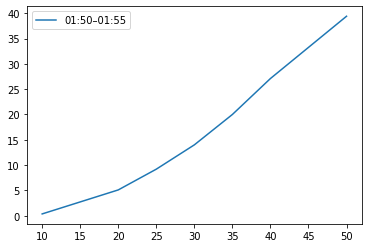

In [70]:
plt.plot([float(col[1]) for col in effective_dose_DF_Mishev.columns[1:]],
         effective_dose_DF_Mishev.iloc[1].to_numpy()[1:],
         label=effective_dose_DF_Mishev.iloc[1].to_numpy()[0])
plt.legend()

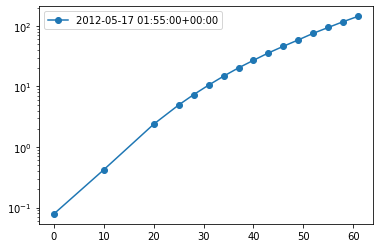

In [71]:
plt.plot(total_flat_edose_DF.columns,total_flat_edose_DF.iloc[0],label = total_flat_edose_DF.iloc[0].name,marker="o")

plt.yscale("log")
plt.legend()

In [72]:
total_flat_edose_DF.reset_index()

altitude (kft)                  datetime       0.0      10.0      20.0  \
0              2012-05-17 01:55:00+00:00  0.078386  0.421785  2.383469   
1              2012-05-17 02:00:00+00:00  0.086514  0.542352  3.337374   
2              2012-05-17 02:05:00+00:00  0.077747  0.420211  2.428861   
3              2012-05-17 02:10:00+00:00  0.077558  0.417321  2.405384   
4              2012-05-17 02:15:00+00:00  0.076951  0.407392  2.320446   
5              2012-05-17 02:20:00+00:00  0.075316  0.381342  2.102382   
6              2012-05-17 02:25:00+00:00  0.075414  0.381919  2.100736   
7              2012-05-17 02:30:00+00:00  0.073695  0.353536  1.857350   
8              2012-05-17 02:35:00+00:00  0.073291  0.346351  1.791852   
9              2012-05-17 02:40:00+00:00  0.072704  0.335747  1.693854   
10             2012-05-17 02:45:00+00:00  0.072621  0.334333  1.681531   
11             2012-05-17 02:50:00+00:00  0.072567  0.333439  1.673838   
12             2012-05-17 02:55:00+00:00  0.072389  0.330369  1.646515   
13             2012-05-17 03:00:00+00:00  0.072313  0.328952  1.633036   
14             2012-05-17 03:05:00+00:00  0.072204  0.326975  1.614836   
15             2012-05-17 03:10:00+00:00  0.072086  0.324883  1.595796   
16             2012-05-17 03:15:00+00:00  0.071965  0.322745  1.576458   
17             2012-05-17 03:20:00+00:00  0.071812  0.320017  1.551371   
18             2012-05-17 03:25:00+00:00  0.071800  0.319785  1.549163   
19             2012-05-17 03:30:00+00:00  0.071823  0.320125  1.551662   
20             2012-05-17 03:35:00+00:00  0.071689  0.317894  1.532476   
21             2012-05-17 03:40:00+00:00  0.071562  0.315741  1.514003   

altitude (kft)      25.0  27.999999999999996       31.0       34.0       37.0  \
0               4.946742            7.332400  10.534592  14.814398  20.315477   
1               7.129164           10.733230  15.634019  22.263456  30.873372   
2               5.097406            7.614721  11.023853  15.651260  21.690204   
3               5.042822            7.528721  10.893474  15.458619  21.414330   
4               4.842115            7.207237  10.398918  14.708381  20.308919   
5               4.330572            6.391943   9.150288  12.824360  17.548068   
6               4.322045            6.373663   9.116069  12.760333  17.435194   
7               3.747873            5.456576   7.709485  10.633286  14.310089   
8               3.590387            5.203561   7.319381  10.044743  13.448103   
9               3.353703            4.822944   6.731965   9.160260  12.155691   
10              3.324525            4.776308   6.660423   9.052115  11.996852   
11              3.306393            4.747387   6.616139   8.985218  11.898643   
12              3.241214            4.643088   6.455912   8.744159  11.546508   
13              3.208362            4.590105   6.373917   8.620852  11.366648   
14              3.164488            4.519546   6.265045   8.456492  11.125781   
15              3.118746            4.446137   6.151979   8.286228  10.876893   
16              3.072370            4.371797   6.037592   8.114246  10.625898   
17              3.011875            4.274642   5.887824   7.889174  10.297675   
18              3.006496            4.265972   5.874413   7.869046  10.268380   
19              3.012009            4.274549   5.887213   7.888525  10.297310   
20              2.966846            4.202601   5.777202   7.722563  10.053981   
21              2.923453            4.133488   5.671602   7.562826   9.819066   

altitude (kft)       40.0       43.0       46.0       49.0        52.0  \
0               27.095109  35.920248  46.246663  59.009248   75.839950   
1               41.552876  55.518867  71.903522  92.148616  118.815458   
2               29.294645  39.602962  51.946131  68.119819   90.758977   
3               28.914268  39.086351  51.269974  67.254521   89.656515   
4               27.341749  36.849598  48.224753  63.181387   84

In [73]:
effective_dose_DF_Mishev

Integration interval/altitude Unnamed: 1_level_0 Unnamed: 2_level_0  \
                       (UT/kft)                 10                 20   
0                          GCRs               0.24                2.5   
1                   01:50–01:55               0.36                5.1   
2                   01:55–02:00               0.46               11.0   
3                   02:10–02:15               0.34                4.8   
4                   02:25–02:30               0.29                4.3   
5                   02:40–02:45               0.27                3.4   
6                   02:55–03:00               0.27                3.1   
7                   03:10–03:15               0.26                2.8   
8                   03:25–03:30               0.26                2.5   
9                   03:40–03:45               0.25                2.0   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                  25                 30                 35                 40   
0                4.0                5.7                8.0               10.0   
1                9.2               14.0               20.0               27.1   
2               17.5               22.0               29.9               41.0   
3                8.5               12.8               20.2               27.0   
4                7.4               11.0               15.7               20.0   
5                6.2               10.0               13.3               17.1   
6                6.0                9.5               12.7               16.0   
7                5.3                8.8               12.0               15.3   
8                5.0                8.3               11.6               14.5   
9                4.7                7.9               11.1               14.0   

  Unnamed: 7_level_0  
                  50  
0               14.4  
1               39.4  
2               59.4  
3               38.8  
4               27.9  
5               23.2  
6               22.0  
7               20.6  
8               20.0  
9               19.5

In [74]:
WASAVIES_GCR_values = np.array([
    [0 / one_kft_in_km,3.8786e-2],
    [2 / one_kft_in_km,1.3091e-1],
    [5 / one_kft_in_km,6.9424e-1],
    [12 / one_kft_in_km,8.0475e0],
    [20 / one_kft_in_km,2.1296e1],
])

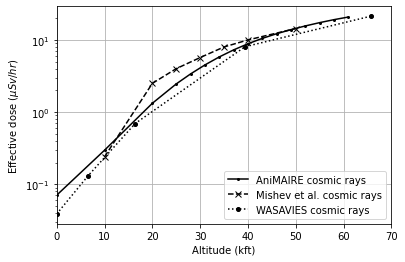

In [75]:
plt.plot(cosmic_ray_initial_map_edose_DF.columns,
             cosmic_ray_initial_map_edose_DF.iloc[0],
             label = "AniMAIRE cosmic rays",
             marker="o",
             ms=2, color="black")

plt.plot([float(col[1]) for col in effective_dose_DF_Mishev.columns[1:]],
            effective_dose_DF_Mishev.iloc[0].to_numpy()[1:],
            label="Mishev et al. cosmic rays",
            marker="x",
            ls="--", color="black",
            ) #color=plt.gca().lines[-1].get_color())

plt.plot(WASAVIES_GCR_values[:,0],WASAVIES_GCR_values[:,1],
         label="WASAVIES cosmic rays",marker="o",ls=":",color="black",ms=4)

#plt.legend(loc="center left",bbox_to_anchor=(1.1,0.5))
plt.legend()

#plt.yscale("log")
#plt.xscale("log")
plt.grid(True)

plt.xlabel("Altitude (kft)")
plt.ylabel(r"Effective dose ($\mu Sv / hr$)")

plt.xlim([0,70])
#plt.ylim([0,25])
plt.yscale("log")

save_image_to_paper_dir("cosmic_rays_comparison",figure_number=7,additional_DF_to_save=cosmic_ray_initial_map_edose_DF)

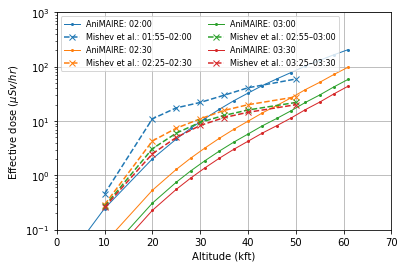

In [76]:
list_of_my_timestamp_indexes = [None,0,1,4,7,10,13,16,19,22]

#for Mishev_index in [1,2,3,4,5,6,7,8]:
for Mishev_index in [2,4,6,8]:
    plt.plot(flat_edose_DF.columns,
             flat_edose_DF.iloc[list_of_my_timestamp_indexes[Mishev_index]],
             label = "AniMAIRE: " + flat_edose_DF.iloc[list_of_my_timestamp_indexes[Mishev_index]].name.strftime("%H:%M"),
             marker="o",
             ms=2, lw=1)

    plt.plot([float(col[1]) for col in effective_dose_DF_Mishev.columns[1:]],
            effective_dose_DF_Mishev.iloc[Mishev_index].to_numpy()[1:],
            label="Mishev et al.: " + effective_dose_DF_Mishev.iloc[Mishev_index].to_numpy()[0],
            marker="x",
            ls="--",
            color=plt.gca().lines[-1].get_color())
    
plt.legend(#loc="center left",bbox_to_anchor=(1.1,0.5),
            ncol=2,fontsize=8)

plt.yscale("log")
plt.ylim([0.1,1e3]) #250])
plt.xlim([0,70])
#plt.xscale("log")
plt.grid(True)

plt.xlabel("Altitude (kft)")
plt.ylabel(r"Effective dose ($\mu Sv / hr$)")

save_image_to_paper_dir("GLE_protons_comparison")

In [77]:
effective_dose_DF_Mishev.head()

Integration interval/altitude Unnamed: 1_level_0 Unnamed: 2_level_0  \
                       (UT/kft)                 10                 20   
0                          GCRs               0.24                2.5   
1                   01:50–01:55               0.36                5.1   
2                   01:55–02:00               0.46               11.0   
3                   02:10–02:15               0.34                4.8   
4                   02:25–02:30               0.29                4.3   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
                  25                 30                 35                 40   
0                4.0                5.7                8.0               10.0   
1                9.2               14.0               20.0               27.1   
2               17.5               22.0               29.9               41.0   
3                8.5               12.8               20.2               27.0   
4                7.4               11.0               15.7               20.0   

  Unnamed: 7_level_0  
                  50  
0               14.4  
1               39.4  
2               59.4  
3               38.8  
4               27.9

In [78]:
def calculate_spectral_index(rigidity, gamma, deltaGamma):
    return gamma + (deltaGamma * (1-rigidity))

In [79]:
def calculate_spectral_index_for_row(Mishev_params_for_event_row):
    mean_rigidity_value = scipy.integrate.quad(
        lambda rigidity:rigidity * CommonModifiedPowerLawSpectrum(
                                Mishev_params_for_event_row.J0,
                                Mishev_params_for_event_row.gamma,
                                Mishev_params_for_event_row.deltaGamma,
                                lowerLimit=0.814529,upperLimit=21.084584
                                )(rigidity),
        0, 100
    )[0] / scipy.integrate.quad(
        CommonModifiedPowerLawSpectrum(
                                Mishev_params_for_event_row.J0,
                                Mishev_params_for_event_row.gamma,
                                Mishev_params_for_event_row.deltaGamma,
                                lowerLimit=0.814529,upperLimit=21.084584
                                ),
        0, 100
    )[0]

    mean_spec_index = calculate_spectral_index(mean_rigidity_value,Mishev_params_for_event_row.gamma,Mishev_params_for_event_row.deltaGamma)

    return mean_spec_index



In [80]:
def gamma_to_WASAVIES_gamma_multiplier(gamma):

    WASAVIES_gamma = 4.5

    return 2**((WASAVIES_gamma - gamma)/0.5)

In [81]:
WASAVIES_comparison_Mishev_params_for_event = Mishev_params_for_event.copy()

#WASAVIES_comparison_Mishev_params_for_event["J0"] = WASAVIES_comparison_Mishev_params_for_event["J0"] / gamma_to_WASAVIES_gamma_multiplier(WASAVIES_comparison_Mishev_params_for_event["gamma"])
#WASAVIES_comparison_Mishev_params_for_event["gamma"] = 4.5

In [82]:
flat_GLE_for_WASAVIES_comparison = {}
#total_flat_GLE_maps = {}

for Mishev_index, Mishev_param_row in WASAVIES_comparison_Mishev_params_for_event.iloc[:-1].iterrows():
    flat_GLE_for_WASAVIES_comparison[Mishev_index] = determine_all_flat_relevant_dose_rates(Mishev_param_row["datetime"],
                                  Mishev_param_row,
                                  station_to_run_for="OULU",
                                  anisotropy_mode = "double_power_law_gaussian",
                                custom_GCR_alpha_spectrum=Force_Field_GCR_alpha_rigidity_spec, #GLE71_force_field_alpha_rigidity_spec,
                                custom_GCR_proton_spectrum=Force_Field_GCR_proton_rigidity_spec,#GLE71_force_field_proton_rigidity_spec) #GCR_interp_Mishev))
                                lats_and_longs_to_run_for = [[90.0,0.0]],
                                generate_NM_count_rates = False,
                                altitudes_to_run_for_in_km=[0.0,2.0,5.0,12.0,20.0],
                                )
    
    flat_GLE_for_WASAVIES_comparison[Mishev_index]["datetime"] = Mishev_param_row["datetime"]

    #total_flat_GLE_maps[Mishev_index] = add_dose_maps(flat_GLE_maps[Mishev_index],cosmic_ray_initial_map)

In [83]:
WASAVIES_edose_DF = pd.read_csv("WASAVIES_GLE71_digitised_datasets.csv",header=[0,1])

def convert_hour_to_dt(hour:float):
    if not np.isnan(hour):
        return dt.timedelta(hours=hour) + dt.datetime(year=2012,month=5,day=17)
    else:
        return np.NaN

for altitude in ["20km","12km","5km","2km","0km"]:
    WASAVIES_edose_DF[(altitude,"X")] = WASAVIES_edose_DF[(altitude,"X")].apply(convert_hour_to_dt)
    
WASAVIES_edose_DF.head()

20km                                  12km            \
                           X          Y                          X         Y   
0 2012-05-17 01:59:10.700559  21.193455 2012-05-17 01:58:26.124790  3.475123   
1 2012-05-17 01:56:46.184500  15.466652 2012-05-17 02:06:48.831477  4.623683   
2 2012-05-17 02:00:35.954190  26.360424 2012-05-17 02:15:10.301433  4.440561   
3 2012-05-17 02:11:20.805035  41.744293 2012-05-17 02:21:18.949268  3.439384   
4 2012-05-17 02:04:22.946404  33.324495 2012-05-17 02:27:01.143850  2.627652   

                         5km                                  2km            \
                           X         Y                          X         Y   
0 2012-05-17 02:00:36.460108  0.138311 2012-05-17 02:01:10.301678  0.015110   
1 2012-05-17 02:10:07.184992  0.156075 2012-05-17 02:10:51.307922  0.015841   
2 2012-05-17 02:17:35.099153  0.122899 2012-05-17 02:18:19.071312  0.011988   
3 2012-05-17 02:22:50.987494  0.096274 2012-05-17 02:23:34.952182  0.009372   
4 2012-05-17 02:30:18.695194  0.071794 2012-05-17 02:31:02.716252  0.007094   

                         0km            
                           X         Y  
0 2012-05-17 02:01:01.882951  0.001643  
1 2012-05-17 02:10:42.819922  0.001691  
2 2012-05-17 02:18:36.888777  0.001248  
3 2012-05-17 02:24:19.081225  0.000953  
4 2012-05-17 02:31:46.900305  0.000732

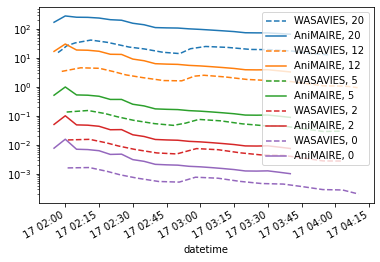

In [84]:
for altitude in np.flip([0,2,5,12,20]):
    WASAVIES_edose_DF[f"{altitude}km"].plot("X","Y",label=f"WASAVIES, {altitude}",ax=plt.gca(),ls="--")
    pd.concat(flat_GLE_for_WASAVIES_comparison).query(f"`altitude (km)` == {altitude}") \
        .plot("datetime","edose",ax=plt.gca(),label=f"AniMAIRE, {altitude}",color=plt.gca().lines[-1].get_color())

plt.yscale("log")

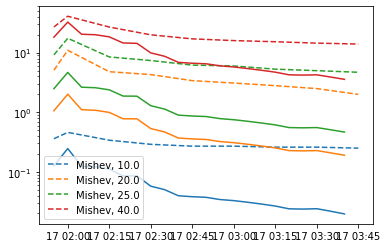

In [85]:

datetimes_to_plot = effective_dose_DF_Mishev.iloc[1:,0].apply(lambda x:dt.timedelta(hours=float(x.split("–")[1].split(":")[0]),
                                                                minutes=float(x.split("–")[1].split(":")[1])) +
                                                    dt.datetime(year=2012,month=5,day=17))

for index, altitude in enumerate([float(col[1]) for col in effective_dose_DF_Mishev.columns[1:]]):
    if altitude in [10.0,20.0,25.0,40.0]:
        plt.plot(flat_edose_DF[altitude].index,
                 flat_edose_DF[altitude]
                 )

        edose_vals = effective_dose_DF_Mishev.iloc[1:,index+1]
        plt.plot(datetimes_to_plot,
                edose_vals,
                label=f"Mishev, {altitude}",ls="--",color=plt.gca().lines[-1].get_color())
    
plt.legend()
plt.yscale("log")

In [86]:
def divide_edose_by_number(inputDF,dividor):

    inputDFcopy = inputDF.copy()
    inputDFcopy["edose"] = inputDFcopy["edose"]/dividor

    return inputDFcopy

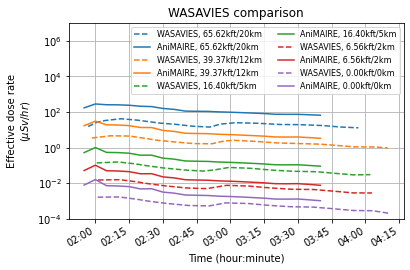

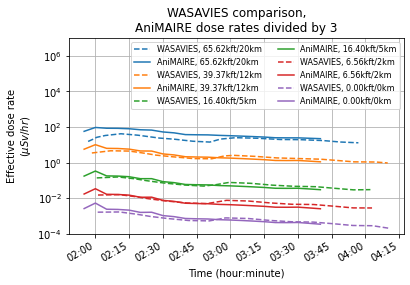

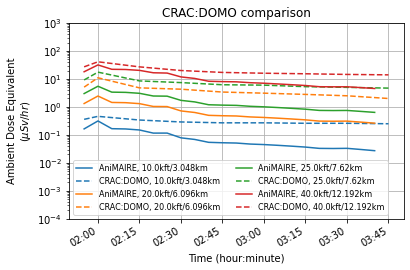

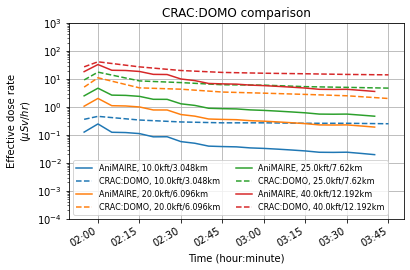

In [87]:
edose_dividor = 1

for altitude in np.flip([0,2,5,12,20]):
    WASAVIES_edose_DF[f"{altitude}km"].plot("X","Y",label=f"WASAVIES, {altitude/one_kft_in_km:.2f}kft/{altitude}km",ax=plt.gca(),ls="--")
    divide_edose_by_number(pd.concat(flat_GLE_for_WASAVIES_comparison),edose_dividor).query(f"`altitude (km)` == {altitude}") \
        .plot("datetime","edose",ax=plt.gca(),label=f"AniMAIRE, {altitude/one_kft_in_km:.2f}kft/{altitude}km",color=plt.gca().lines[-1].get_color())

plt.yscale("log")
plt.ylim([1e-4,1e7])

plt.legend(#bbox_to_anchor=(1.1,0.5),loc="center left",
            fontsize=8,ncol=2)
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (hour:minute)")
plt.ylabel("Effective dose rate\n($\mu Sv / hr$)")

plt.title("WASAVIES comparison")

save_image_to_paper_dir("WASAVIES_comparison",figure_number=7,additional_DF_to_save=WASAVIES_edose_DF,additional_DF_label="_WASAVIES")
save_image_to_paper_dir("WASAVIES_comparison",figure_number=7,additional_DF_to_save=divide_edose_by_number(pd.concat(flat_GLE_for_WASAVIES_comparison),edose_dividor),additional_DF_label="_AniMAIRE")

############################

plt.figure()

edose_dividor = 3

for altitude in np.flip([0,2,5,12,20]):
    WASAVIES_edose_DF[f"{altitude}km"].plot("X","Y",label=f"WASAVIES, {altitude/one_kft_in_km:.2f}kft/{altitude}km",ax=plt.gca(),ls="--")
    divide_edose_by_number(pd.concat(flat_GLE_for_WASAVIES_comparison),edose_dividor).query(f"`altitude (km)` == {altitude}") \
        .plot("datetime","edose",ax=plt.gca(),label=f"AniMAIRE, {altitude/one_kft_in_km:.2f}kft/{altitude}km",color=plt.gca().lines[-1].get_color())

plt.yscale("log")
plt.ylim([1e-4,1e7])

plt.legend(#bbox_to_anchor=(1.1,0.5),loc="center left",
            fontsize=8,ncol=2)
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (hour:minute)")
plt.ylabel("Effective dose rate\n($\mu Sv / hr$)")

plt.title("WASAVIES comparison,\nAniMAIRE dose rates divided by 3")

save_image_to_paper_dir("WASAVIES_comparison_divided_by_3",figure_number=7,additional_DF_to_save=divide_edose_by_number(pd.concat(flat_GLE_for_WASAVIES_comparison),edose_dividor),additional_DF_label="_AniMAIRE_divided_by_3")

###########################

plt.figure()

datetimes_to_plot = effective_dose_DF_Mishev.iloc[1:,0].apply(lambda x:dt.timedelta(hours=float(x.split("–")[1].split(":")[0]),
                                                                minutes=float(x.split("–")[1].split(":")[1])) +
                                                    dt.datetime(year=2012,month=5,day=17))

for index, altitude in enumerate([float(col[1]) for col in effective_dose_DF_Mishev.columns[1:]]):
    if altitude in [10.0,20.0,25.0,40.0]:
        plt.plot(flat_adose_DF[altitude].index,
                 flat_adose_DF[altitude],
                 label=f"AniMAIRE, {altitude}kft/{altitude * one_kft_in_km}km"
                 )

        edose_vals = effective_dose_DF_Mishev.iloc[1:,index+1]
        plt.plot(datetimes_to_plot,
                edose_vals,
                label=f"CRAC:DOMO, {altitude}kft/{altitude * one_kft_in_km}km",ls="--",color=plt.gca().lines[-1].get_color())
    
plt.legend(#bbox_to_anchor=(1.1,0.5),
           #loc="center left",
           fontsize=8,ncol=2)
plt.yscale("log")

plt.ylim([1e-4,1e3])
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (hour:minute)")
plt.ylabel("Ambient Dose Equivalent\n($\mu Sv / hr$)")

plt.gcf().autofmt_xdate()

plt.title("CRAC:DOMO comparison")

###########################

plt.figure()

datetimes_to_plot = effective_dose_DF_Mishev.iloc[1:,0].apply(lambda x:dt.timedelta(hours=float(x.split("–")[1].split(":")[0]),
                                                                minutes=float(x.split("–")[1].split(":")[1])) +
                                                    dt.datetime(year=2012,month=5,day=17))

for index, altitude in enumerate([float(col[1]) for col in effective_dose_DF_Mishev.columns[1:]]):
    if altitude in [10.0,20.0,25.0,40.0]:
        plt.plot(flat_edose_DF[altitude].index,
                 flat_edose_DF[altitude],
                 label=f"AniMAIRE, {altitude}kft/{altitude * one_kft_in_km}km"
                 )

        edose_vals = effective_dose_DF_Mishev.iloc[1:,index+1]
        plt.plot(datetimes_to_plot,
                edose_vals,
                label=f"CRAC:DOMO, {altitude}kft/{altitude * one_kft_in_km}km",ls="--",color=plt.gca().lines[-1].get_color())
    
plt.legend(#bbox_to_anchor=(1.1,0.5),
           #loc="center left",
           fontsize=8,ncol=2)
plt.yscale("log")

plt.ylim([1e-4,1e3])
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (hour:minute)")
plt.ylabel("Effective dose rate\n($\mu Sv / hr$)")

plt.gcf().autofmt_xdate()

plt.title("CRAC:DOMO comparison")

save_image_to_paper_dir("Mishev_comparison",figure_number=7,additional_DF_to_save=effective_dose_DF_Mishev,additional_DF_label="_CRAC_DOMO")

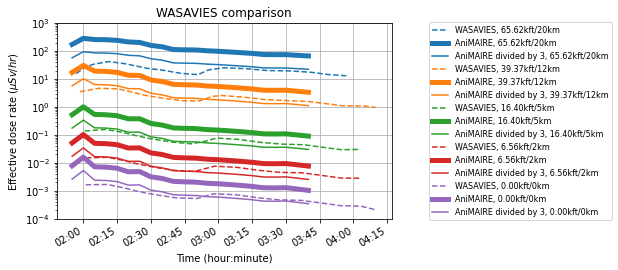

In [88]:
plt.figure()

edose_dividor = 3

for altitude in np.flip([0,2,5,12,20]):
    WASAVIES_edose_DF[f"{altitude}km"].plot("X","Y",label=f"WASAVIES, {altitude/one_kft_in_km:.2f}kft/{altitude}km",ax=plt.gca(),ls="--")
    divide_edose_by_number(pd.concat(flat_GLE_for_WASAVIES_comparison),1).query(f"`altitude (km)` == {altitude}") \
        .plot("datetime","edose",ax=plt.gca(),label=f"AniMAIRE, {altitude/one_kft_in_km:.2f}kft/{altitude}km",
              color=plt.gca().lines[-1].get_color(),lw=5)
    divide_edose_by_number(pd.concat(flat_GLE_for_WASAVIES_comparison),edose_dividor).query(f"`altitude (km)` == {altitude}") \
        .plot("datetime","edose",ax=plt.gca(),
              label=f"AniMAIRE divided by 3, {altitude/one_kft_in_km:.2f}kft/{altitude}km",
              color=plt.gca().lines[-1].get_color())

plt.yscale("log")
plt.ylim([1e-4,1e3])

plt.legend(bbox_to_anchor=(1.1,0.5),loc="center left",fontsize=8)
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (hour:minute)")
plt.ylabel(r"Effective dose rate ($\mu Sv / hr$)")

plt.title("WASAVIES comparison")

save_image_to_paper_dir("WASAVIES_comparison_all")

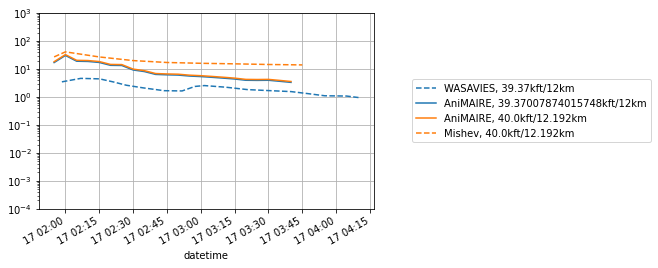

In [89]:
edose_dividor = 1

for altitude in np.flip([12]):
    WASAVIES_edose_DF[f"{altitude}km"].plot("X","Y",label=f"WASAVIES, {altitude/one_kft_in_km:.2f}kft/{altitude}km",ax=plt.gca(),ls="--")
    divide_edose_by_number(pd.concat(flat_GLE_for_WASAVIES_comparison),edose_dividor).query(f"`altitude (km)` == {altitude}") \
        .plot("datetime","edose",ax=plt.gca(),label=f"AniMAIRE, {altitude/one_kft_in_km}kft/{altitude}km",color=plt.gca().lines[-1].get_color())

plt.yscale("log")
plt.ylim([1e-4,1e3])

plt.legend(bbox_to_anchor=(1.1,0.5),loc="center left")
plt.grid(True)

###########################

datetimes_to_plot = effective_dose_DF_Mishev.iloc[1:,0].apply(lambda x:dt.timedelta(hours=float(x.split("–")[1].split(":")[0]),
                                                                minutes=float(x.split("–")[1].split(":")[1])) +
                                                    dt.datetime(year=2012,month=5,day=17))

for index, altitude in enumerate([float(col[1]) for col in effective_dose_DF_Mishev.columns[1:]]):
    if altitude in [40.0]:
        plt.plot(flat_edose_DF[altitude].index,
                 flat_edose_DF[altitude],
                 label=f"AniMAIRE, {altitude}kft/{altitude * one_kft_in_km}km"
                 )

        edose_vals = effective_dose_DF_Mishev.iloc[1:,index+1]
        plt.plot(datetimes_to_plot,
                edose_vals,
                label=f"Mishev, {altitude}kft/{altitude * one_kft_in_km}km",ls="--",color=plt.gca().lines[-1].get_color())
    
plt.legend(bbox_to_anchor=(1.1,0.5),loc="center left")
plt.yscale("log")

plt.ylim([1e-4,1e3])
plt.grid(True)

<AxesSubplot:xlabel='datetime'>

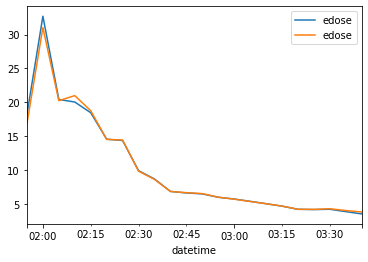

In [90]:
pd.concat(flat_GLE_maps).query("`altitude (km)` == 12.192").query("latitude == 90.0").query("longitude == 0.0").plot("datetime","edose")

#AnistropicMaxDoseRates = pd.concat(GLE_maps).groupby(["datetime","altitude (km)"]).max().reset_index()
AnistropicMaxDoseRates = pd.concat(GLE_maps).groupby(["datetime","altitude (km)"]).agg(lambda x:heapq.nlargest(1,x)[-1]).reset_index()
AnistropicMaxDoseRates.query("`altitude (km)` == 12.192").plot("datetime","edose",ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

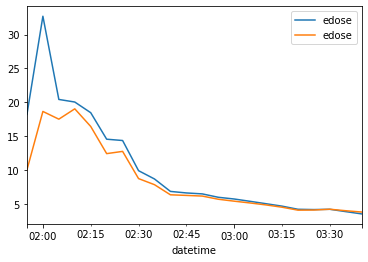

In [91]:
pd.concat(flat_GLE_maps).query("`altitude (km)` == 12.192").query("latitude == 90.0").query("longitude == 0.0").plot("datetime","edose")

#AnistropicMaxDoseRates = pd.concat(GLE_maps).groupby(["datetime","altitude (km)"]).max().reset_index()
AnistropicMaxDoseRates = pd.concat(GLE_maps).groupby(["datetime","altitude (km)"]).agg(lambda x:heapq.nlargest(50,x)[-1]).reset_index()
AnistropicMaxDoseRates.query("`altitude (km)` == 12.192").plot("datetime","edose",ax=plt.gca())

## Animations

In [92]:
import matplotlib.animation as animation

In [93]:
def plot_50_kft_map(time_index):
    #plt.figure()
    plot_GLE_map(GLE_maps_50kft[time_index],
                plot_title=f"altitude = 50 kft, date and time = {Mishev_params_for_event.datetime.iloc[time_index]}",
                edgecolor=None)

In [94]:
def plot_39_kft_map(time_index,dict_of_maps=GLE_maps_39kft,levels=[5,15,25,35],calc_total_doses=False, plot_contours=True, label="Anisotropic"):

    if calc_total_doses is True:
        map_to_plot = add_dose_maps(dict_of_maps[time_index],cosmic_ray_initial_map_39kft_only)
    else:
        map_to_plot = dict_of_maps[time_index]

    #plt.figure()
    plt.clf()
    plt.gca().set_title("")
    plot_GLE_map(map_to_plot,
                plot_title=f"{label} GLE Spectra only\naltitude = 39 kft, date and time = {Mishev_params_for_event.datetime.iloc[time_index]}",
                edgecolor=None,
                hue_range=(0,40),
                legend_label=r"Effective dose ($\mu Sv / hr$)",
                palette="Spectral_r",
                #plot_colorbar=False,
                levels=levels,
                plot_contours=plot_contours,
                plot_longitude_east=False)
    plt.gca().set_title("")
    plt.gca().text(x=0.0,y=100.0,s=f"{label} GLE Spectra only\naltitude = 39 kft, date and time = {Mishev_params_for_event.datetime.iloc[time_index]}",
                    zorder=10000,fontsize=18,horizontalalignment="center",backgroundcolor="white",alpha=1)

In [95]:
def save_funcanimation_to_paper_dir(base_file_name:str, func_to_animate=plot_39_kft_map, save=default_to_saving):

    if save is True:
        fig = plt.figure()

        ani = animation.FuncAnimation(fig, func_to_animate,frames=22,blit=False)

        #To save the animation using Pillow as a gif
        writer = animation.PillowWriter(fps=1,
                                        metadata=dict(artist='Dr Chris S. W. Davis'),
                                        bitrate=1800)
                                        
        ani.save(f"./animations/{base_file_name}.gif", writer=writer, dpi=300)

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),


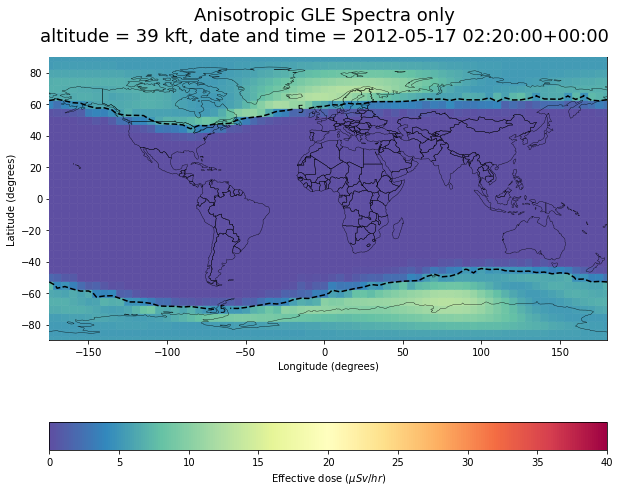

In [96]:
plot_39_kft_map(1)
plt.clf()
plot_39_kft_map(5)


In [97]:
for label,GLE_maps_dict in [("anisotropic",GLE_maps_39kft), ("isotropic",flat_GLE_maps_39kft)]:
    save_funcanimation_to_paper_dir(base_file_name=f'39kft_heatmap_animation_{label}', func_to_animate=lambda x:plot_39_kft_map(x,GLE_maps_dict,label=label))
    save_funcanimation_to_paper_dir(base_file_name=f'39kft_heatmap_animation_no_contours_{label}', func_to_animate=lambda x:plot_39_kft_map(x,GLE_maps_dict,label=label,plot_contours=False))

    save_funcanimation_to_paper_dir(base_file_name=f'39kft_heatmap_animation_total_dose_{label}', func_to_animate=lambda x:plot_39_kft_map(x,GLE_maps_dict,label=label,calc_total_doses=True))
    save_funcanimation_to_paper_dir(base_file_name=f'39kft_heatmap_animation_no_contours_total_dose_{label}', func_to_animate=lambda x:plot_39_kft_map(x,GLE_maps_dict,label=label,plot_contours=False,calc_total_doses=True))

/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contour_lats,interp(contour_longs, contour_lats),
/tmp/ipykernel_3936/598821748.py:11: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'hue_range', 'legend_label', 'palette', 'plot_longitude_east'
  contours = plt.contour(contour_longs,contou